# Importing Libraries

In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import date
import missingno as msno
from scipy.stats import norm
from scipy.signal import find_peaks
from scipy.signal import argrelextrema

pd.set_option('display.max_columns', 500)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 10000)
pd.set_option("display.float_format", lambda x: f"{x:.10f}")

from sklearn.utils import resample
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from matplotlib import rc,rcParams
import itertools
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')


# Relative Strength Index (RSI)

In [224]:
def calculate_rsi(price_data, window=14, price_col='close'):
    """
    Correct RSI calculation.
    """
    delta = price_data[price_col].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


# Categorical RSI  

In [225]:
def categorize_rsi(rsi_series):
    """
    Categorize RSI values into bins:
    0-30, 30-50, 50-70, 70-100

    Args:
        rsi_series (pd.Series): RSI values

    Returns:
        pd.Series: Categorical RSI bins
    """
    bins = [0, 30, 50, 70, 100]
    labels = ['oversold', 'below_avg', 'above_avg', 'overbought']
    return pd.cut(rsi_series, bins=bins, labels=labels, include_lowest=True)


# Average True Range (ATR)

In [226]:
def calculate_atr(price_data, window=14):
    """
    Calculate ATR (Average True Range) using Wilder's RMA.

    Args:
        price_data (pd.DataFrame): DataFrame containing columns 'high', 'low', 'close'
        window (int): Lookback period (default: 14)

    Returns:
        pd.Series: ATR values
    """
    high = price_data['high']
    low = price_data['low']
    close = price_data['close']

    # Calculate True Range (TR)
    previous_close = close.shift(1)
    tr1 = high - low
    tr2 = abs(high - previous_close)
    tr3 = abs(low - previous_close)
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # ATR = RMA of True Range
    atr = true_range.ewm(alpha=1/window, adjust=False).mean()

    return atr

# Bollinger Bands

In [227]:
def calculate_bollinger_bands(price_data, window=20, std_multiplier=2, price_col='close'):
    """
    Calculate Bollinger Bands.

    Args:
        price_data (pd.DataFrame): DataFrame containing OHLC prices
        window (int): Lookback period for SMA (default: 20)
        std_multiplier (float): Standard deviation multiplier (default: 2)
        price_col (str): Column name for price (default: 'close')

    Returns:
        pd.DataFrame: DataFrame with 'bb_middle', 'bb_upper', 'bb_lower' columns
    """
    price = price_data[price_col]

    # Middle Band: SMA
    sma = price.rolling(window=window).mean()

    # Standard Deviation
    std = price.rolling(window=window).std()

    # Upper and Lower Bands
    upper_band = sma + std_multiplier * std
    lower_band = sma - std_multiplier * std

    # Return as DataFrame
    bb = pd.DataFrame({
        'bb_middle': sma,
        'bb_upper': upper_band,
        'bb_lower': lower_band
    })

    return bb


# Donchain Channels

In [228]:
#USE 20, 50 OR 55

def calculate_donchian_channel(price_data, window=20):
    """
    Calculate Donchian Channel.

    Args:
        price_data (pd.DataFrame): DataFrame with 'high' and 'low' columns
        window (int): Lookback period (default: 20)

    Returns:
        pd.DataFrame: DataFrame with 'dc_upper', 'dc_lower', 'dc_middle'
    """
    upper_band = price_data['high'].rolling(window=window).max()
    lower_band = price_data['low'].rolling(window=window).min()
    middle_band = (upper_band + lower_band) / 2

    dc = pd.DataFrame({
        'dc_upper': upper_band,
        'dc_lower': lower_band,
        'dc_middle': middle_band
    })

    return dc


# Simple Moving Average - SMA

In [229]:
# USE 13, 50, 100 OR 200

def calculate_sma(price_data, window=50, price_col='close'):
    """
    Calculate Simple Moving Average (SMA).

    Args:
        price_data (pd.DataFrame): DataFrame containing price data
        window (int): Lookback period for SMA (default: 50)
        price_col (str): Column name for price (default: 'close')

    Returns:
        pd.Series: SMA values
    """
    sma = price_data[price_col].rolling(window=window).mean()
    return sma


# Trend

In [230]:
def determine_sma_trend(price_data, short_window=50, long_window=200, price_col='close'):
    """
    Determine trend based on SMA crossover.

    Args:
        price_data (pd.DataFrame): DataFrame containing price data
        short_window (int): Short SMA period (default: 13)
        long_window (int): Long SMA period (default: 50)
        price_col (str): Column name for price (default: 'close')

    Returns:
        pd.Series: Trend labels ('uptrend' or 'downtrend')
    """
    short_sma = price_data[price_col].rolling(window=short_window).mean()
    long_sma = price_data[price_col].rolling(window=long_window).mean()

    trend = np.where(short_sma > long_sma, 'uptrend', 'downtrend')

    return pd.Series(trend, index=price_data.index)


# EMA

In [231]:
def calculate_ema(df, window=50, column='close'):
    """
    DataFrame için EMA (Exponential Moving Average) hesaplar

    Parameters:
    df (pd.DataFrame): Fiyat verilerini içeren DataFrame
    window (int): EMA periyodu (varsayılan: 50)
    column (str): Kullanılacak sütun adı (varsayılan: 'close')

    Returns:
    pd.Series: Hesaplanan EMA değerleri
    """

    # Düzgünleştirme faktörü (alpha)
    alpha = 2 / (window + 1)

    # EMA hesaplama - pandas ewm fonksiyonu kullanarak
    ema = df[column].ewm(alpha=alpha, adjust=False).mean()

    return ema

# Nadaraya Watson Envelope

In [232]:
def calculate_nadaraya_watson_envelope_optimized(df, bandwidth=8.0, multiplier=3.0, source_col='close', window_size=50):# window_size=500 kullanımı da var.
    """
    Nadaraya-Watson Envelope'un repaint olmayan modunu hesaplar.
    Sadece hesaplanan 'nw_lower', 'nw', 'nw_upper' sütunlarını içeren bir DataFrame döndürür.

    Parametreler:
    df (pd.DataFrame): 'close', 'open', 'high', 'low', 'time' sütunlarına sahip DataFrame.
    bandwidth (float): Nadaraya-Watson için bant genişliği (h).
    multiplier (float): Zarfların genişliğini ayarlamak için çarpan.
    source_col (str): Hesaplama için kullanılacak kaynak sütun adı (örn: 'close').
    window_size (int): Nadaraya-Watson ve MAE hesaplamalarında kullanılacak maksimum geçmiş bar sayısı.

    Döndürür:
    pd.DataFrame: 'nw_lower', 'nw', 'nw_upper' sütunlarını içeren yeni bir DataFrame.
                  Bu DataFrame'in indeksleri orijinal df ile aynı olacaktır.
    """

    n_bars = len(df)
    source_data = df[source_col].values # NumPy array'ine dönüştürerek erişimi hızlandır

    # Gaussian kernel fonksiyonu
    def gauss(x, h):
        return np.exp(-(x**2) / (h * h * 2))

    # Ağırlıkları bir kere hesapla
    weights = np.array([gauss(i, bandwidth) for i in range(window_size)])
    weights_sum = np.sum(weights)

    # Sonuçları saklamak için NumPy array'leri oluştur (önceden bellek tahsisi)
    nw_out_arr = np.full(n_bars, np.nan)
    nw_lower_arr = np.full(n_bars, np.nan)
    nw_upper_arr = np.full(n_bars, np.nan)

    # Her bar için hesaplama yap
    for i in range(n_bars):
        if i < window_size - 1:
            continue

        # Nadaraya-Watson çizgisi (nw_out) hesaplaması
        # NumPy dilimleme ve dot product kullanarak hızlandırılmış hesaplama
        # source_data[i - window_size + 1 : i + 1] son 'window_size' kadar veriyi alır
        # weights[::-1] ağırlıkları ters çevirir çünkü en yakın veriye en yüksek ağırlık gelir
        weighted_sum = np.dot(source_data[i - window_size + 1 : i + 1], weights[::-1])

        current_nw_out = weighted_sum / weights_sum
        nw_out_arr[i] = current_nw_out

        # MAE hesaplaması (Artık 'nw_out_arr' değerlerini kullanarak daha doğru bir MAE)
        # Sadece yeterli geçmiş veri olduğunda hesapla
        if i >= window_size -1:
            # Geçmiş src ve nw_out farklarını al
            abs_diffs = np.abs(source_data[i - window_size + 1 : i + 1] - nw_out_arr[i - window_size + 1 : i + 1])
            current_mae = np.mean(abs_diffs) * multiplier # ta.sma'ya benzer

            nw_lower_arr[i] = current_nw_out - current_mae
            nw_upper_arr[i] = current_nw_out + current_mae

    # Sonuçları yeni bir DataFrame olarak döndür
    results_df = pd.DataFrame({
        'nw': nw_out_arr,
        'nw_upper': nw_upper_arr,
        'nw_lower': nw_lower_arr
    }, index=df.index) # Orijinal DataFrame'in indeksini koru

    return results_df

# Stochastic

In [233]:
def calculate_stochastic(price_data, k_length=50, k_smoothing=21, d_smoothing=8):
    """
    TradingView style Stochastic Oscillator.

    Args:
        price_data (pd.DataFrame): must have 'High', 'Low', 'Close'
        k_length (int): %K Length (lookback)
        k_smoothing (int): %K Smoothing
        d_smoothing (int): %D Smoothing

    Returns:
        pd.DataFrame: 'stoch_k', 'stoch_d'
    """
    low_min = price_data['low'].rolling(window=k_length).min()
    high_max = price_data['high'].rolling(window=k_length).max()

    raw_k = 100 * (price_data['close'] - low_min) / (high_max - low_min)
    stoch_k = raw_k.rolling(window=k_smoothing).mean()
    stoch_d = stoch_k.rolling(window=d_smoothing).mean()

    return pd.DataFrame({
        'stoch_k': stoch_k,
        'stoch_d': stoch_d
    })


# Stochastic RSI

In [234]:
def rma(series, length):
    """Wilder's RMA: TradingView'deki ta.rma ile birebir."""
    alpha = 1 / length
    rma = series.ewm(alpha=alpha, adjust=False).mean()
    return rma

def calculate_stoch_rsi(
    price_data,
    rsi_length=14,
    stoch_length=14,
    k_smoothing=21,
    d_smoothing=8,
    price_col='close'
):
    """
    TradingView birebir Stoch RSI — RMA tabanlı

    Returns:
        'stoch_rsi_k', 'stoch_rsi_d' (0-100)
    """
    # 1) RSI (RMA tabanlı)
    delta = price_data[price_col].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = rma(gain, rsi_length)
    avg_loss = rma(loss, rsi_length)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # 2) Stoch RSI
    rsi_min = rsi.rolling(window=stoch_length).min()
    rsi_max = rsi.rolling(window=stoch_length).max()

    stoch_rsi = 100 * (rsi - rsi_min) / (rsi_max - rsi_min)
    stoch_rsi = stoch_rsi.clip(0, 100)

    # 3) %K ve %D smoothing — RMA tabanlı
    stoch_rsi_k = rma(stoch_rsi, k_smoothing)
    stoch_rsi_d = rma(stoch_rsi_k, d_smoothing)

    return pd.DataFrame({
        'stoch_rsi_k': stoch_rsi_k,
        'stoch_rsi_d': stoch_rsi_d
    })


# MACD

In [235]:
def calculate_macd(price_data, fast=21, slow=50, signal=9, price_col='close'):
    """
    Calculate MACD and Signal Line.

    Args:
        price_data (pd.DataFrame): must have price_col
        fast (int): Fast EMA period
        slow (int): Slow EMA period
        signal (int): Signal line EMA period

    Returns:
        pd.DataFrame: 'macd_line', 'macd_signal', 'macd_hist'
    """
    ema_fast = price_data[price_col].ewm(span=fast, adjust=False).mean()
    ema_slow = price_data[price_col].ewm(span=slow, adjust=False).mean()

    macd_line = ema_fast - ema_slow
    macd_signal = macd_line.ewm(span=signal, adjust=False).mean()
    macd_hist = macd_line - macd_signal

    return pd.DataFrame({
        'macd_line': macd_line,
        'macd_signal': macd_signal,
        'macd_hist': macd_hist
    })


# ADX

In [236]:
def add_adx(df, period=14):
    """
    DataFrame'e ADX (Average Directional Index) göstergesini ekler.

    Parametreler:
    df (pd.DataFrame): 'high', 'low' ve 'close' sütunlarını içeren DataFrame.
                       Sütun isimlerinin küçük harf olduğundan emin olun.
    period (int): ADX hesaplaması için kullanılacak periyot (varsayılan 14).

    Döndürür:
    pd.DataFrame: ADX, +DI, -DI ve DX sütunları eklenmiş DataFrame.
    """

    # Gerekli sütunların küçük harf kontrolü ve hata yönetimi
    required_cols = ['high', 'low', 'close']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame'de '{', '.join(required_cols)}' sütunları bulunmalıdır ve küçük harf olmalıdır.")

    # Geçici çalışma DataFrame'i oluştur (orijinal df'i değiştirmemek için kopyala)
    df_adx = df.copy()

    # --- Yardımcı EMA Hesaplama Fonksiyonu ---
    def _calculate_ema(series, p):
        ema_values = [np.nan] * len(series)
        if len(series) < p:
            return pd.Series(ema_values, index=series.index)

        # İlk EMA değeri için SMA kullanılır
        ema_values[p - 1] = series.iloc[:p].mean()

        alpha = 2 / (p + 1)
        for i in range(p, len(series)):
            ema_values[i] = (series.iloc[i] * alpha) + (ema_values[i-1] * (1 - alpha))

        return pd.Series(ema_values, index=series.index)

    # --- 1. Adım: True Range (TR) Hesapla ---
    # TR = Max[(high - low), abs(high - prev_close), abs(low - prev_close)]
    df_adx['prev_close'] = df_adx['close'].shift(1)
    df_adx['high_low'] = df_adx['high'] - df_adx['low']
    df_adx['high_prev_close'] = abs(df_adx['high'] - df_adx['prev_close'])
    df_adx['low_prev_close'] = abs(df_adx['low'] - df_adx['prev_close'])
    df_adx['tr'] = df_adx[['high_low', 'high_prev_close', 'low_prev_close']].max(axis=1)

    # --- 2. Adım: Directional Movement (+DM ve -DM) Hesapla ---
    df_adx['prev_high'] = df_adx['high'].shift(1)
    df_adx['prev_low'] = df_adx['low'].shift(1)
    df_adx['up_move'] = df_adx['high'] - df_adx['prev_high']
    df_adx['down_move'] = df_adx['prev_low'] - df_adx['low']

    df_adx['+dm'] = np.where(
        (df_adx['up_move'] > df_adx['down_move']) & (df_adx['up_move'] > 0),
        df_adx['up_move'],
        0
    )
    df_adx['-dm'] = np.where(
        (df_adx['down_move'] > df_adx['up_move']) & (df_adx['down_move'] > 0),
        df_adx['down_move'],
        0
    )

    # --- 3. Adım: ATR, +DM ve -DM'nin Üssel Hareketli Ortalamalarını (EMA) Hesapla ---
    df_adx['tr_ema'] = _calculate_ema(df_adx['tr'], period)
    df_adx['+dm_ema'] = _calculate_ema(df_adx['+dm'], period)
    df_adx['-dm_ema'] = _calculate_ema(df_adx['-dm'], period)

    # --- 4. Adım: Yönsel İndeksler (DI) Hesapla ---
    df_adx['+di'] = (df_adx['+dm_ema'] / df_adx['tr_ema']) * 100
    df_adx['-di'] = (df_adx['-dm_ema'] / df_adx['tr_ema']) * 100

    # Sonsuzlukları ve sıfıra bölme hatalarını yönet
    df_adx['+di'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_adx['-di'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_adx.loc[df_adx['tr_ema'] == 0, ['+di', '-di']] = np.nan

    # --- 5. Adım: Yönsel Hareket İndeksi (DX) Hesapla ---
    df_adx['dx'] = (abs(df_adx['+di'] - df_adx['-di']) / (df_adx['+di'] + df_adx['-di'])) * 100
    df_adx['dx'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_adx.loc[(df_adx['+di'] + df_adx['-di']) == 0, 'dx'] = np.nan

    # --- 6. Adım: ADX Hesapla (DX'in EMA'sı) ---
    df_adx['adx'] = _calculate_ema(df_adx['dx'], period)

    # İstenirse ara hesaplama sütunlarını temizle
    # df_adx.drop(columns=['prev_close', 'high_low', 'high_prev_close', 'low_prev_close',
    #                      'prev_high', 'prev_low', 'up_move', 'down_move',
    #                      'tr', '+dm', '-dm', 'tr_ema', '+dm_ema', '-dm_ema', 'dx'],
    #                     errors='ignore', inplace=True)

    return df_adx

# OBV

In [237]:
def add_obv(df):
    """
    DataFrame'e OBV (On-Balance Volume) göstergesini ekler.

    Parametreler:
    df (pd.DataFrame): 'close' ve 'volume' sütunlarını içeren DataFrame.
                       Sütun isimlerinin küçük harf olduğundan emin olun.

    Döndürür:
    pd.DataFrame: 'obv' sütunu eklenmiş DataFrame.
    """

    # Gerekli sütunların küçük harf kontrolü ve hata yönetimi
    required_cols = ['close', 'volume']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame'de '{', '.join(required_cols)}' sütunları bulunmalıdır ve küçük harf olmalıdır.")

    # Geçici çalışma DataFrame'i oluştur (orijinal df'i değiştirmemek için kopyala)
    df_obv = df.copy()

    # OBV sütununu başlat, ilk değeri 0 veya ilk barın hacmi olabilir.
    # Genellikle ilk barın hacmi alınır.
    df_obv['obv'] = 0.0 # float olarak başlat

    # İlk OBV değeri: İlk kapanış ve hacim verisi kullanılarak belirlenir
    # df_obv['obv'].iloc[0] = df_obv['volume'].iloc[0] # Bu da bir yaklaşım
    # Ancak sıfırdan başlamak da yaygındır ve sonraki hesaplamayı etkilemez

    # Döngü ile OBV'yi hesapla
    for i in range(1, len(df_obv)):
        # Kapanış fiyatlarının önceki kapanışa göre karşılaştırılması
        if df_obv['close'].iloc[i] > df_obv['close'].iloc[i-1]:
            # Fiyat yükseldi, hacmi ekle
            df_obv['obv'].iloc[i] = df_obv['obv'].iloc[i-1] + df_obv['volume'].iloc[i]
        elif df_obv['close'].iloc[i] < df_obv['close'].iloc[i-1]:
            # Fiyat düştü, hacmi çıkar
            df_obv['obv'].iloc[i] = df_obv['obv'].iloc[i-1] - df_obv['volume'].iloc[i]
        else:
            # Fiyat değişmedi, OBV aynı kalır
            df_obv['obv'].iloc[i] = df_obv['obv'].iloc[i-1]

    return df_obv

# Candle

In [238]:
def candle(df):
    if df['close'] > df['open']:
        return'green'
    else:
        return 'red'

def classify_strength(row):
    if row['close'] > row['open']:
        if row['candle_strength'] > 1.1:
            return 'strong_bullish'
        elif row['candle_strength'] > 0.7:
            return 'medium_bullish'
        else:
            return 'weak_bullish'
    else:
        if row['candle_strength'] > 1.1:
            return 'strong_bearish'
        elif row['candle_strength'] > 0.7:
            return 'medium_bearish'
        else:
            return 'weak_bearish'

# Zigzag

In [239]:
def zigzag(prices, pct=2):
    last_pivot = prices[0]
    pivots = [np.nan] * len(prices)
    directions = [0] * len(prices)
    direction = 0  # 1: up, -1: down

    for i in range(1, len(prices)):
        change = (prices[i] - last_pivot) / last_pivot * 100

        if direction >= 0 and change <= -pct:  # düşüş pivotu (tepe)
            direction = -1
            pivots[i] = prices[i]
            directions[i] = -1
            last_pivot = prices[i]
        elif direction <= 0 and change >= pct:  # yükseliş pivotu (dip)
            direction = 1
            pivots[i] = prices[i]
            directions[i] = 1
            last_pivot = prices[i]
    return pivots, directions

# Zigzag-ATR

In [240]:
def atr_zigzag(df, atr_col="atr", close_col="close"):
    """
    ATR bazlı zigzag (strict mode).
    Yeni pivot, ancak ters yönde 1 ATR hareket olunca kesinleşir.
    """
    closes = df[close_col].values
    atrs = df[atr_col].values

    pivots = [None] * len(df)
    last_pivot = closes[0]
    last_atr = atrs[0]
    last_pivot_idx = 0
    direction = None  # "up" veya "down"

    for i in range(1, len(df)):
        price = closes[i]
        atr = atrs[i]

        if direction is None:
            # henüz yön yok → ilk büyük hareket yönü belirler
            if price >= last_pivot + atr:
                direction = "up"
                last_pivot = closes[last_pivot_idx]
                pivots[last_pivot_idx] = last_pivot
            elif price <= last_pivot - atr:
                direction = "down"
                last_pivot = closes[last_pivot_idx]
                pivots[last_pivot_idx] = last_pivot

        elif direction == "up":
            # fiyat yükseliyor
            if price <= (last_pivot - last_atr):
                # son pivot teyit edildi → bu bir tepeydi
                pivots[last_pivot_idx] = last_pivot
                direction = "down"
                last_pivot = price
                last_pivot_idx = i
                last_atr = atr
            elif price > last_pivot:
                # en yüksek noktayı güncelle (ama teyit etme!)
                last_pivot = price
                last_pivot_idx = i
                last_atr = atr

        elif direction == "down":
            # fiyat düşüyor
            if price >= (last_pivot + last_atr):
                # son pivot teyit edildi → bu bir dipti
                pivots[last_pivot_idx] = last_pivot
                direction = "up"
                last_pivot = price
                last_pivot_idx = i
                last_atr = atr
            elif price < last_pivot:
                # en düşük noktayı güncelle (ama teyit etme!)
                last_pivot = price
                last_pivot_idx = i
                last_atr = atr

    df["atr_zigzag"] = pivots
    return df

# Zigzag ATR High-Low

In [241]:
def atr_zigzag_two_columns(df, atr_col="atr", close_col="close", atr_mult=1):
    """
    ATR bazlı strict zigzag, high ve low pivotları ayrı sütunlarda.
    Ayrıca pivot teyidi hangi barda geldiğini ve kaç bar geciktiğini işaretler.

    Params:
        df : DataFrame
        atr_col : str -> ATR kolon adı
        close_col : str -> Kapanış fiyatı kolon adı
        atr_mult : float -> Kaç ATR kullanılacak (1, 2, 3 ...)
    """
    closes = df[close_col].values
    atrs = df[atr_col].values

    high_pivot = [None] * len(df)
    low_pivot = [None] * len(df)
    high_pivot_confirmed = [0] * len(df)
    low_pivot_confirmed = [0] * len(df)
    pivot_bars_ago = [None] * len(df)

    last_pivot = closes[0]
    last_atr = atrs[0]
    last_pivot_idx = 0
    direction = None  # "up" veya "down"

    for i in range(1, len(df)):
        price = closes[i]
        atr = atrs[i] * atr_mult  # ATR çarpanı uygulanıyor

        if direction is None:
            if price >= last_pivot + atr:
                direction = "up"
                last_pivot = closes[last_pivot_idx]
                high_pivot[last_pivot_idx] = last_pivot
            elif price <= last_pivot - atr:
                direction = "down"
                last_pivot = closes[last_pivot_idx]
                low_pivot[last_pivot_idx] = last_pivot

        elif direction == "up":
            if price <= (last_pivot - atr):
                # ✅ Tepe teyit edildi
                high_pivot[last_pivot_idx] = last_pivot
                high_pivot_confirmed[i] = 1
                pivot_bars_ago[i] = i - last_pivot_idx

                direction = "down"
                last_pivot = price
                last_pivot_idx = i
            elif price > last_pivot:
                # Tepe güncelle, teyit etme
                last_pivot = price
                last_pivot_idx = i

        elif direction == "down":
            if price >= (last_pivot + atr):
                # ✅ Dip teyit edildi
                low_pivot[last_pivot_idx] = last_pivot
                low_pivot_confirmed[i] = 1
                pivot_bars_ago[i] = i - last_pivot_idx

                direction = "up"
                last_pivot = price
                last_pivot_idx = i
            elif price < last_pivot:
                # Dip güncelle, teyit etme
                last_pivot = price
                last_pivot_idx = i

    df["high_pivot"] = high_pivot
    df["low_pivot"] = low_pivot
    df["high_pivot_confirmed"] = high_pivot_confirmed
    df["low_pivot_confirmed"] = low_pivot_confirmed
    df["pivot_bars_ago"] = pivot_bars_ago
    return df




In [242]:
def atr_zigzag_two_columns(df, atr_col="atr", close_col="close", atr_mult=1):
    """
    ATR bazlı strict zigzag, high ve low pivotları ayrı sütunlarda.
    Ayrıca pivot teyidi hangi barda geldiğini ve kaç bar geciktiğini işaretler.
    NaN değerler son pivot değerleriyle doldurulur.

    Params:
        df : DataFrame
        atr_col : str -> ATR kolon adı
        close_col : str -> Kapanış fiyatı kolon adı
        atr_mult : float -> Kaç ATR kullanılacak (1, 2, 3 ...)
    """
    closes = df[close_col].values
    atrs = df[atr_col].values

    high_pivot = [None] * len(df)
    low_pivot = [None] * len(df)
    high_pivot_confirmed = [0] * len(df)
    low_pivot_confirmed = [0] * len(df)
    pivot_bars_ago = [None] * len(df)

    last_pivot = closes[0]
    last_atr = atrs[0]
    last_pivot_idx = 0
    direction = None  # "up" veya "down"

    for i in range(1, len(df)):
        price = closes[i]
        atr = atrs[i] * atr_mult  # ATR çarpanı uygulanıyor

        if direction is None:
            if price >= last_pivot + atr:
                direction = "up"
                last_pivot = closes[last_pivot_idx]
                high_pivot[last_pivot_idx] = last_pivot
            elif price <= last_pivot - atr:
                direction = "down"
                last_pivot = closes[last_pivot_idx]
                low_pivot[last_pivot_idx] = last_pivot

        elif direction == "up":
            if price <= (last_pivot - atr):
                # ✅ Tepe teyit edildi
                high_pivot[last_pivot_idx] = last_pivot
                high_pivot_confirmed[i] = 1
                pivot_bars_ago[i] = i - last_pivot_idx

                direction = "down"
                last_pivot = price
                last_pivot_idx = i
            elif price > last_pivot:
                # Tepe güncelle, teyit etme
                last_pivot = price
                last_pivot_idx = i

        elif direction == "down":
            if price >= (last_pivot + atr):
                # ✅ Dip teyit edildi
                low_pivot[last_pivot_idx] = last_pivot
                low_pivot_confirmed[i] = 1
                pivot_bars_ago[i] = i - last_pivot_idx

                direction = "up"
                last_pivot = price
                last_pivot_idx = i
            elif price < last_pivot:
                # Dip güncelle, teyit etme
                last_pivot = price
                last_pivot_idx = i

    # Önce orijinal sütunları oluştur
    df["high_pivot"] = high_pivot
    df["low_pivot"] = low_pivot
    df["high_pivot_confirmed"] = high_pivot_confirmed
    df["low_pivot_confirmed"] = low_pivot_confirmed
    df["pivot_bars_ago"] = pivot_bars_ago

    # NaN değerleri doldurma işlemleri
    # high_pivot ve low_pivot için forward fill
    df["high_pivot_filled"] = df["high_pivot"].ffill()
    df["low_pivot_filled"] = df["low_pivot"].ffill()

    # high_pivot_confirmed ve low_pivot_confirmed için forward fill
    # Burada 0/1 değerlerini korumak için özel bir yaklaşım
    df["high_pivot_confirmed_filled"] = df["high_pivot_confirmed"].replace(to_replace=0, value=None).ffill().fillna(0).astype(int)
    df["low_pivot_confirmed_filled"] = df["low_pivot_confirmed"].replace(to_replace=0, value=None).ffill().fillna(0).astype(int)

    # pivot_bars_ago için özel doldurma - her satırda 1 artırarak
    pivot_bars_filled = []
    last_valid_value = None
    last_valid_index = None

    for i, value in enumerate(pivot_bars_ago):
        if value is not None:
            last_valid_value = value
            last_valid_index = i
            pivot_bars_filled.append(value)
        elif last_valid_value is not None:
            # NaN değeri, son geçerli değer + (mevcut index - son geçerli index)
            new_value = last_valid_value + (i - last_valid_index)
            pivot_bars_filled.append(new_value)
        else:
            # İlk değerler için
            pivot_bars_filled.append(None)

    df["pivot_bars_ago_filled"] = pivot_bars_filled

    return df

# DATAFRAME

In [243]:
#df = pd.read_csv('/content/TRX_USD_1h_2y.csv',header=0, skiprows=[1,2])
#df = df.rename(columns={'Price': 'datetime',})
#df.columns = df.columns.str.lower()
#df['datetime'] = pd.to_datetime(df['datetime'])

df = pd.read_csv('/content/BINANCE_SOLUSDT, 15.csv')
df.columns = df.columns.str.lower()
df['time'] = pd.to_datetime(df['time'])

df.tail()

,time,open,high,low,close,volume
20298,2025-06-30 13:30:00+03:00,150.2700000000,150.3900000000,150.0300000000,150.3700000000,8678.9790000000
20299,2025-06-30 13:45:00+03:00,150.3700000000,150.4100000000,150.1900000000,150.3100000000,10309.2010000000
20300,2025-06-30 14:00:00+03:00,150.3100000000,150.5000000000,150.0800000000,150.3600000000,8645.2020000000
20301,2025-06-30 14:15:00+03:00,150.3500000000,151.0500000000,150.1700000000,150.7500000000,75849.6640000000
20302,2025-06-30 14:30:00+03:00,150.7400000000,150.8500000000,150.6900000000,150.7400000000,5547.3070000000


In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20303 entries, 0 to 20302
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype                    
---  ------  --------------  -----                    
 0   time    20303 non-null  datetime64[ns, UTC+03:00]
 1   open    20303 non-null  float64                  
 2   high    20303 non-null  float64                  
 3   low     20303 non-null  float64                  
 4   close   20303 non-null  float64                  
 5   volume  20303 non-null  float64                  
dtypes: datetime64[ns, UTC+03:00](1), float64(5)
memory usage: 951.8 KB


## Creating Main Columns

In [245]:
df['time'] = pd.to_datetime(df['time'], utc=True).dt.tz_convert("UTC")

df['rsi'] = calculate_rsi(df)
df['cat_rsi'] = categorize_rsi(df['rsi'])
df['rsi_40'] = calculate_rsi(df, window=40)
df['atr'] = calculate_atr(df)

bb = calculate_bollinger_bands(df)
df['bb_middle'] = bb['bb_middle']
df['bb_upper'] = bb['bb_upper']
df['bb_lower'] = bb['bb_lower']

dc = calculate_donchian_channel(df, window=20)
df['dc_upper_20'] = dc['dc_upper']
df['dc_lower_20'] = dc['dc_lower']
df['dc_middle_20'] = dc['dc_middle']

dc = calculate_donchian_channel(df, window=50)
df['dc_upper_50'] = dc['dc_upper']
df['dc_lower_50'] = dc['dc_lower']
df['dc_middle_50'] = dc['dc_middle']

df['sma_50'] = calculate_sma(df,window=50)
df['sma_200'] = calculate_sma(df,window=200)
df['sma_200_4h'] = calculate_sma(df,window=800)
df['sma_50_rate'] = df['close'] / df['sma_50']


df['trend_13_50']=determine_sma_trend(df, short_window=13, long_window=50)
df['trend_50_200']=determine_sma_trend(df, short_window=50, long_window=200)
df['trend_4h_50_200']=determine_sma_trend(df, short_window=200, long_window=800)

df['ema'] = calculate_ema(df, window=50)
df['ema_20'] = calculate_ema(df, window=20)
df['ema_50_rate'] = df['close'] / df['ema']
df['ema_20_rate'] = df['close'] / df['ema_20']

nw_bands = calculate_nadaraya_watson_envelope_optimized(df, bandwidth=8.0, multiplier=3.0, source_col='close', window_size=50)
df['nw'] = nw_bands['nw']
df['nw_upper'] = nw_bands['nw_upper']
df['nw_lower'] = nw_bands['nw_lower']




stoch = calculate_stochastic(df)
df['stoch_k'] = stoch['stoch_k']
df['stoch_d'] = stoch['stoch_d']

stoch_rsi = calculate_stoch_rsi(df)
df['stoch_rsi_k'] = stoch_rsi['stoch_rsi_k']
df['stoch_rsi_d'] = stoch_rsi['stoch_rsi_d']

macd = calculate_macd(df)
df['macd_line'] = macd['macd_line'] # blue line
df['macd_signal'] = macd['macd_signal'] # orange line
df['macd_hist'] = macd['macd_hist']


df['candle'] = df.apply(candle, axis=1)
df['candle_body'] = abs(df['close'] - df['open'])
df['candle_strength'] = df['candle_body'] / df['atr']
df['candle_class'] = df.apply(classify_strength, axis=1)

df['volume_price'] = df['volume'] / df['close']
df['volume_candle'] = df['volume'] * abs(df['close'] - df['open']) / df['close']

df = add_adx(df, period=14)

df = add_obv(df)

In [246]:
# local max ve min bul
df["zigzag_high"] = df["close"].iloc[argrelextrema(df["high"].values, np.greater_equal, order=10)[0]]
df["zigzag_low"]  = df["close"].iloc[argrelextrema(df["low"].values, np.less_equal, order=10)[0]]

# son görülen pivotları ileri taşı
df["last_high"] = df["zigzag_high"].ffill()
df["last_low"]  = df["zigzag_low"].ffill()

# pozisyon ve trend
df["zigzag_position"] = (df["close"] - df["last_low"]) / (df["last_high"] - df["last_low"]) * 100

df["high_trend"] = np.where(df["last_high"] > df["last_high"].shift(), "up",
                            np.where(df["last_high"] < df["last_high"].shift(), "down", None))

df["low_trend"] = np.where(df["last_low"] > df["last_low"].shift(), "up",
                           np.where(df["last_low"] < df["last_low"].shift(), "down", None))

In [247]:
df = atr_zigzag(df)

# Zigzag + Pivot Confirmed

In [248]:
df = atr_zigzag_two_columns(df, atr_col="atr", close_col="close", atr_mult=2)

In [249]:
# ATR Moves Analysis
def build_pivot_legs(df,
                     atr_col="atr",
                     high_pivot_col="high_pivot",
                     low_pivot_col="low_pivot",
                     high_col="high",
                     low_col="low",
                     close_col="close",
                     compute_entry_stats=True):
    """
    Zigzag pivotları (high_pivot/low_pivot) arasındaki her 'bacak' için
    ATR katını ve opsiyonel entry istatistiklerini hesaplar.

    Ayrıca df'teki tüm sütunları legs_df'e taşır (entry ve exit için ayrı sütunlar).
    """

    # 1) Pivotları sıraya koy
    pivots = []
    for idx, row in df.iterrows():
        if pd.notna(row.get(low_pivot_col, np.nan)):
            pivots.append({"type": "L", "idx": idx, "price": row[low_pivot_col], "atr": row[atr_col]})
        if pd.notna(row.get(high_pivot_col, np.nan)):
            pivots.append({"type": "H", "idx": idx, "price": row[high_pivot_col], "atr": row[atr_col]})
    pivots.sort(key=lambda x: x["idx"])

    # Aynı tip arka arkaya gelirse sonuncuyu tut
    cleaned = []
    for p in pivots:
        if not cleaned or cleaned[-1]["type"] != p["type"]:
            cleaned.append(p)
        else:
            cleaned[-1] = p
    pivots = cleaned

    legs = []
    for i in range(len(pivots) - 1):
        a = pivots[i]
        b = pivots[i + 1]

        start_idx   = a["idx"]
        end_idx     = b["idx"]
        start_type  = a["type"]
        end_type    = b["type"]
        direction   = "up" if start_type == "L" else "down"
        start_price = a["price"]
        end_price   = b["price"]
        start_atr   = a["atr"]
        bars        = int(end_idx - start_idx)
        move        = end_price - start_price
        move_abs    = abs(move)
        atr_mult    = move_abs / start_atr if (start_atr and start_atr > 0) else np.nan

        entry_idx = None
        entry_price = None
        bars_to_entry = None
        mfe_R = None
        triggered = False

        if compute_entry_stats and bars > 0 and (start_atr is not None) and start_atr > 0:
            # Entry kuralı: pivot + 1*ATR kırılması
            thresh = start_price + start_atr if direction == "up" else start_price - start_atr
            seg = df.loc[start_idx:end_idx]

            has_hl = (high_col in df.columns) and (low_col in df.columns)
            if direction == "up":
                hit = seg[seg[high_col] >= thresh] if has_hl else seg[seg[close_col] >= thresh]
            else:
                hit = seg[seg[low_col] <= thresh] if has_hl else seg[seg[close_col] <= thresh]

            if len(hit) > 0:
                entry_idx = hit.index[0]
                entry_price = thresh
                bars_to_entry = int(entry_idx - start_idx)
                triggered = True
                mfe_R = (end_price - entry_price) / start_atr if direction == "up" else (entry_price - end_price) / start_atr

        # df'teki entry ve exit satırlarını al
        entry_row = df.loc[start_idx].to_dict()
        exit_row = df.loc[end_idx].to_dict()

        # prefix ekle
        entry_prefixed = {f"entry_{k}": v for k, v in entry_row.items()}
        exit_prefixed = {f"exit_{k}": v for k, v in exit_row.items()}

        legs.append({
            "start_idx": start_idx,
            "end_idx": end_idx,
            "direction": direction,
            "start_type": start_type,
            "end_type": end_type,
            "start_price": start_price,
            "end_price": end_price,
            "start_atr": start_atr,
            "bars": bars,
            "price_move": move,
            "abs_move": move_abs,
            "atr_multiple": atr_mult,
            "entry_triggered": triggered,
            "entry_idx": entry_idx,
            "entry_price": entry_price,
            "bars_to_entry": bars_to_entry,
            "mfe_R_until_end_pivot": mfe_R,
            **entry_prefixed,
            **exit_prefixed
        })

    legs_df = pd.DataFrame(legs)
    return legs_df


In [250]:
legs_df = build_pivot_legs(df)

# Peaks-Valleys

In [251]:
# Yerel zirveler (High)
peaks, _ = find_peaks(df['high'], distance=20)   # distance = en az kaç bar aralıklı olsun
df['local_high'] = np.nan
df.loc[peaks, 'local_high'] = df['high']

# Yerel dipler (Low) için High'ın -Low versiyonu
valleys, _ = find_peaks(-df['low'], distance=10)
df['local_low'] = np.nan
df.loc[valleys, 'local_low'] = df['low']

# NaN’leri son pivot değeriyle doldur
df['local_high'] = df['local_high'].ffill()
df['local_low']  = df['local_low'].ffill()

# Derivative Variables

## Donchian Channel Positions

In [252]:
df['dc_position_ratio_20'] = (df['close'] - df['dc_lower_20']) / (df['dc_upper_20'] - df['dc_lower_20']) * 100

conditions = [
    (df['dc_position_ratio_20'] < 10),
    (df['dc_position_ratio_20'] >= 10) & (df['dc_position_ratio_20'] < 25),
    (df['dc_position_ratio_20'] >= 25) & (df['dc_position_ratio_20'] < 40),
    (df['dc_position_ratio_20'] >= 40) & (df['dc_position_ratio_20'] < 60),
    (df['dc_position_ratio_20'] >= 60) & (df['dc_position_ratio_20'] < 75),
    (df['dc_position_ratio_20'] >= 75) & (df['dc_position_ratio_20'] < 90),
    (df['dc_position_ratio_20'] >= 90)
]

choices = [
    '0-10',
    '10-25',
    '25-40',
    '40-60',
    '60-75',
    '75-90',
    '90-100'
]

df['dc_position_20'] = np.select(conditions, choices, default='Bilinmeyen')

df['dc_position_ratio_50'] = (df['close'] - df['dc_lower_50']) / (df['dc_upper_50'] - df['dc_lower_50']) * 100


df['dc_position_50'] = np.select(conditions, choices, default='Bilinmeyen')


df['dc_breakout_20'] = df['high'] > df['dc_upper_20']
df['dc_breakdown_20'] = df['low'] < df['dc_lower_20']

df['dc_breakout_50'] = df['high'] > df['dc_upper_50']
df['dc_breakdown_50'] = df['low'] < df['dc_lower_50']

## BB Position

In [253]:
def bb_position(row):
    if row['high'] > row['bb_upper']:
        return 'above_upper'
    elif row['close'] > row['bb_middle']:
        return 'above_middle'
    elif row['close'] > row['bb_lower']:
        return 'below_middle'
    else:
        return 'below_lower'

df['bb_position'] = df.apply(bb_position, axis=1)

def calculate_bb_percentage_position(row):
    # Eğer herhangi bir bant değeri NaN ise veya bant genişliği sıfırsa (hata önleme)
    if pd.isna(row['bb_upper']) or pd.isna(row['bb_lower']) or pd.isna(row['close']):
        return np.nan

    band_range = row['bb_upper'] - row['bb_lower']

    # Bant genişliği sıfırsa veya çok küçükse (bölme hatasını önlemek için)
    if band_range <= 0.00000000000000001: # Küçük bir eşik değeri kullan
        if row['close'] > row['bb_upper']:
            return 'above_100' # Üst bandın üzerinde
        elif row['close'] < row['bb_lower']:
            return 'below_0'   # Alt bandın altında
        else:
            return 'within_bands_narrow' # Bantlar aşırı dar veya çakışık

    # Yüzdelik konumu hesapla (Bollinger Band Percentage)
    bbp = ((row['close'] - row['bb_lower']) / band_range) * 100

    # Kategorilere ayırma
    if bbp >= 100:
        return 'above_100'       # Fiyat üst bandın üzerinde
    elif bbp >= 75:
        return '75-100'          # Üst bandın %75'i ile %100'ü arasında
    elif bbp >= 50:
        return '50-75'           # Ortalamanın üzeri, %50 ile %75 arasında
    elif bbp >= 25:
        return '25-50'           # Ortalamanın altı, %25 ile %50 arasında
    elif bbp >= 0:
        return '0-25'            # Alt bandın %0'ı ile %25'i arasında
    else:
        return 'below_0'         # Fiyat alt bandın altında

df['bb_position'] = df.apply(calculate_bb_percentage_position, axis=1)


## Stochastic Position & Cross

In [254]:
def stoch_position(value):
    if value <= 20:
        return 'very_low'
    elif value <= 50:
        return 'low'
    elif value <= 80:
        return 'high'
    else:
        return 'very_high'

df['stoch_position'] = df['stoch_k'].apply(stoch_position)

df['stoch_cross_up'] = (df['stoch_k'] > df['stoch_d']) & (df['stoch_k'].shift(1) <= df['stoch_d'].shift(1))
df['stoch_cross_down'] = (df['stoch_k'] < df['stoch_d']) & (df['stoch_k'].shift(1) >= df['stoch_d'].shift(1))


## Nadaraya Watson Position

In [255]:
def nw_position(row):
    if row['close'] > row['nw_upper']:
        return 'above_upper'
    elif row['close'] > row['nw']:
        return 'above_middle'
    elif row['close'] > row['nw_lower']:
        return 'below_middle'
    else:
        return 'below_lower'

df['nw_position'] = df.apply(nw_position, axis=1)


## ADX Position

In [256]:
df['adx_category'] = None

# DataFrame üzerinde satır satır döngü yapalım
for index, row in df.iterrows():
    adx_value = row['adx']

    if pd.isna(adx_value): # Eğer ADX değeri NaN ise kategoriyi de NaN yap
        df.loc[index, 'adx_category'] = np.nan
    elif adx_value < 25:
        df.loc[index, 'adx_category'] = 'weak_trend'
    elif adx_value >= 25 and adx_value < 40: # 15 dahil, 30 hariç
        df.loc[index, 'adx_category'] = 'medium_trend'
    elif adx_value >= 40 and adx_value < 60: # 15 dahil, 30 hariç
        df.loc[index, 'adx_category'] = 'strong_trend'
    else: # adx_value >= 60
        df.loc[index, 'adx_category'] = 'super_strong_trend'

## SMA Cross

In [257]:
# Fark hesapla
df['diff_50_200'] = df['sma_50'] - df['sma_200']

# Önceki fark
df['diff_50_200_prev'] = df['diff_50_200'].shift(1)

# Yönlü crossover
df['sma_cross_up'] = (df['diff_50_200'] > 0) & (df['diff_50_200_prev'] <= 0)
df['sma_cross_down'] = (df['diff_50_200'] < 0) & (df['diff_50_200_prev'] >= 0)

# Fark hesapla
df['diff_50_200_4h'] = df['sma_200'] - df['sma_200_4h']

# Önceki fark
df['diff_50_200_4h_prev'] = df['diff_50_200'].shift(1)

# Yönlü crossover
df['sma_cross_up_4h'] = (df['diff_50_200_4h'] > 0) & (df['diff_50_200_4h_prev'] <= 0)
df['sma_cross_down_4h'] = (df['diff_50_200_4h'] < 0) & (df['diff_50_200_4h_prev'] >= 0)


## Percent ATR

In [258]:
df['pct_atr'] = df['atr'] / df['close'] * 100

# BB - DC Width Rate

In [259]:
df['bb_width_rate'] = df['bb_upper'] / df['bb_lower']
df['dc_50_width_rate'] = df['dc_upper_50'] / df['dc_lower_50']
df['dc_20_width_rate'] = df['dc_upper_20'] / df['dc_lower_20']

In [260]:
def width_rate_position_np(df, col, low_width, high_width):
    conditions = [
        df[col] < low_width,
        df[col] > high_width
    ]
    choices = ['narrow', 'wide']
    df[col + '_position'] = np.select(conditions, choices, default='middle-wide')
    return df

In [261]:
low_dc_width = df['dc_50_width_rate'].quantile(0.15)
high_dc_width = df['dc_50_width_rate'].quantile(0.85)
low_dc_width_20 = df['dc_20_width_rate'].quantile(0.15)
high_dc_width_20 = df['dc_20_width_rate'].quantile(0.85)
low_bb_width = df['bb_width_rate'].quantile(0.15)
high_bb_width = df['bb_width_rate'].quantile(0.85)

df = width_rate_position_np(df, 'dc_50_width_rate', low_dc_width, high_dc_width)
df = width_rate_position_np(df, 'dc_20_width_rate', low_dc_width_20, high_dc_width_20)
df = width_rate_position_np(df, 'bb_width_rate', low_bb_width, high_bb_width)

In [262]:
low_pct_atr = df['pct_atr'].quantile(0.15)
high_pct_atr = df['pct_atr'].quantile(0.85)
df = width_rate_position_np(df, 'pct_atr', low_pct_atr, high_pct_atr)

# BB Strategies - 1 Or 3 Touch - Trend or Not

In [263]:
def bb_touch_signal(df, touch_count=1, trend_filter=False, trend_col='trend_50_200', trend_direction='uptrend'):
    """
    BB üst banda veya alt banda temas sayısına göre Long/Short sinyali.

    Params:
        df: DataFrame with BB bands & trend
        touch_count: int (1 veya 3)
        trend_filter: bool (True → trend şartı aranır)
        trend_col: str (ör. 'sma_trend')
        trend_direction: 'uptrend' veya 'downtrend'

    Returns:
        pd.Series: True where signal occurs
    """
    df['bb_touch_upper'] = df['high'] >= df['bb_upper']
    df['bb_touch_lower'] = df['low'] <= df['bb_lower']

    # Son 'touch_count' bardaki temas toplamı
    touch_upper = sum([df['bb_touch_upper'].shift(i+1) for i in range(touch_count)])
    touch_lower = sum([df['bb_touch_lower'].shift(i+1) for i in range(touch_count)])

    signal_long = touch_upper >= touch_count
    signal_short = touch_lower >= touch_count

    if trend_filter:
        signal_long = signal_long & (df[trend_col] == trend_direction)
        signal_short = signal_short & (df[trend_col] != trend_direction)

    return pd.Series(signal_long, index=df.index), pd.Series(signal_short, index=df.index)


# DC Strategies - Trend or Not

In [264]:
def dc_breakout_signal(df, dc_upper='dc_upper_20', dc_lower='dc_lower_20',
                       trend_filter=False, trend_col='trend_50_200', trend_direction='uptrend'):
    """
    DC breakout sinyali.

    Params:
        dc_upper: Üst kanal kolonu
        dc_lower: Alt kanal kolonu
        trend_filter: Trend filtresi kullanılacak mı?
        trend_col: Trend kolonu ismi
        trend_direction: Beklenen trend yönü ('uptrend' veya 'downtrend')

    Returns:
        long_signal, short_signal: pd.Series (bool)
    """
    # DC breakout: şu anki high, bir önceki üst bandın üstüne çıktı mı?
    breakout_upper = df['high'] > df[dc_upper].shift(1)
    breakout_lower = df['low'] < df[dc_lower].shift(1)

    signal_long = breakout_upper
    signal_short = breakout_lower

    if trend_filter:
        signal_long &= (df[trend_col] == trend_direction)
        signal_short &= (df[trend_col] != trend_direction)

    return pd.Series(signal_long, index=df.index), pd.Series(signal_short, index=df.index)



# NW Strategies



In [265]:
def nw_breakout_signal(df, band_ratio=0.2):
    """
    Nadaraya-Watson breakout sinyali.
    NW bandının belirli bir oran üzerinde aşılması durumunda long/short sinyali üretir.

    Args:
        df (pd.DataFrame): Fiyat verisi içeren DataFrame.
        band_ratio (float): Band genişliğinin yüzdesi. Örn. 0.2 → %20

    Returns:
        pd.Series: signal_long, signal_short
    """
    band_width = df['nw_upper'] - df['nw_lower']

    excess_upper = df['high'] > df['nw_upper'].shift(1) + band_ratio * band_width.shift(1)
    excess_lower = df['low'] < df['nw_lower'].shift(1) - band_ratio * band_width.shift(1)

    signal_long = excess_lower
    signal_short = excess_upper

    return pd.Series(signal_long, index=df.index), pd.Series(signal_short, index=df.index)



# MACD - Stochastic and Two Dots Signal

In [266]:
def macd_signal_generator_bool(macd_df):
    """
    MACD göstergelerine göre True/False alım/satım sinyalleri üretir.

    Args:
        macd_df (pd.DataFrame): 'macd_line' ve 'macd_signal' sütunlarını içeren MACD DataFrame'i.

    Returns:
        tuple: (macd_long_signal, macd_short_signal)
               macd_long_signal (pd.Series): Long sinyallerini içeren Series (True/False).
               macd_short_signal (pd.Series): Short sinyallerini içeren Series (True/False).
    """
    # Long sinyali (MACD çizgisi sinyal çizgisini yukarı keser)
    long_signals = (macd_df['macd_line'] > macd_df['macd_signal']) & \
                   (macd_df['macd_line'].shift(1) <= macd_df['macd_signal'].shift(1))

    # Short sinyali (MACD çizgisi sinyal çizgisini aşağı keser)
    short_signals = (macd_df['macd_line'] < macd_df['macd_signal']) & \
                    (macd_df['macd_line'].shift(1) >= macd_df['macd_signal'].shift(1))

    return long_signals, short_signals

In [267]:
def stoch_signal_generator_bool(stoch_df):
    """
    Stokastik göstergelere göre True/False alım/satım sinyalleri üretir.

    Args:
        stoch_df (pd.DataFrame): 'stoch_k' ve 'stoch_d' sütunlarını içeren Stokastik DataFrame'i.

    Returns:
        tuple: (stoch_long_signal, stoch_short_signal)
               stoch_long_signal (pd.Series): Long sinyallerini içeren Series (True/False).
               stoch_short_signal (pd.Series): Short sinyallerini içeren Series (True/False).
    """
    # Yukarı kesişim (long sinyali)
    stoch_cross_up = (stoch_df['stoch_k'] > stoch_df['stoch_d']) & \
                     (stoch_df['stoch_k'].shift(1) <= stoch_df['stoch_d'].shift(1))

    # Aşağı kesişim (short sinyali)
    stoch_cross_down = (stoch_df['stoch_k'] < stoch_df['stoch_d']) & \
                       (stoch_df['stoch_k'].shift(1) >= stoch_df['stoch_d'].shift(1))

    return stoch_cross_up, stoch_cross_down

In [268]:
def two_dots_signal_bool(macd_signals, stoch_signals, window=5):
    """
    MACD ve Stokastik sinyallerini birleştirerek yeni bir True/False sinyal üretir.
    Her iki sinyal de belirli bir pencere içinde aynı yönde ise True sinyal üretir.

    Args:
        macd_signals (tuple): macd_signal_generator_bool'dan dönen (long_signals, short_signals) tuple'ı.
        stoch_signals (tuple): stoch_signal_generator_bool'dan dönen (long_signals, short_signals) tuple'ı.
        window (int): İki sinyalin aynı yönde oluşması için bakılacak geçmiş veri birimi sayısı.

    Returns:
        tuple: (two_dots_long_signal, two_dots_short_signal)
               two_dots_long_signal (pd.Series): Birleşik long sinyallerini içeren Series (True/False).
               two_dots_short_signal (pd.Series): Birleşik short sinyallerini içeren Series (True/False).
    """
    # Gelen sinyalleri ayır
    macd_long_signal, macd_short_signal = macd_signals
    stoch_long_signal, stoch_short_signal = stoch_signals

    combined_long_signals = pd.Series(False, index=macd_long_signal.index)
    combined_short_signals = pd.Series(False, index=macd_long_signal.index)

    for i in range(len(macd_long_signal)):
        # Long sinyali için pencere kontrolü
        long_conditions_met = False
        for j in range(max(0, i - window + 1), i + 1):
            if macd_long_signal.iloc[j] and stoch_long_signal.iloc[j]:
                long_conditions_met = True
                break

        if long_conditions_met:
            combined_long_signals.iloc[i] = True

        # Short sinyali için pencere kontrolü
        short_conditions_met = False
        for j in range(max(0, i - window + 1), i + 1):
            if macd_short_signal.iloc[j] and stoch_short_signal.iloc[j]:
                short_conditions_met = True
                break

        if short_conditions_met:
            combined_short_signals.iloc[i] = True

    return combined_long_signals, combined_short_signals


In [269]:
# MACD Sinyallerini al
long_macd_signal, short_macd_signal = macd_signal_generator_bool(df)
df['macd_long_signal'] = long_macd_signal
df['macd_short_signal'] = short_macd_signal

# Stokastik Sinyallerini al
long_stoch_signal, short_stoch_signal = stoch_signal_generator_bool(df)
df['stoch_long_signal'] = long_stoch_signal
df['stoch_short_signal'] = short_stoch_signal

two_dots_long, two_dots_short = two_dots_signal_bool(
    (df['macd_long_signal'], df['macd_short_signal']),
    (df['stoch_long_signal'], df['stoch_short_signal']),
    window=5
)

df['two_dots_long'] = two_dots_long
df['two_dots_short'] = two_dots_short


In [270]:
# DC 20 breakout
long_dc20, short_dc20 = dc_breakout_signal(df, 'dc_upper_20', 'dc_lower_20',trend_col='trend_50_200', trend_filter=True)
df['dc_breakout_20'] = long_dc20
df['dc_breakdown_20'] = short_dc20
# DC 50 breakout
long_dc50, short_dc50 = dc_breakout_signal(df, 'dc_upper_50', 'dc_lower_50', trend_filter=True)
df['dc_breakout_50'] = long_dc50
df['dc_breakdown_50'] = short_dc50


# BB bir kere temas long/short
long1, short1 = bb_touch_signal(df, touch_count=1, trend_filter=True)
df['bb_1_touch_long'] = long1
df['bb_1_touch_short'] = short1
# BB üç kere temas long/short
long3, short3 = bb_touch_signal(df, touch_count=3, trend_filter=True)
df['bb_3_touch_long'] = long3
df['bb_3_touch_short'] = short3


# NW signal
long_nw, short_nw = nw_breakout_signal(df, band_ratio=0.2)
df['nw_long'] = long_nw
df['nw_short'] = short_nw


# BB.ELF Signal

In [271]:
# Long tarafı için
no_long_touch_last_10 = df['bb_3_touch_long'].shift(1).rolling(window=10).sum() == 0
df['bb_3_touch_long_clean'] = df['bb_3_touch_long'] & no_long_touch_last_10

# Short tarafı için
no_short_touch_last_10 = df['bb_3_touch_short'].shift(1).rolling(window=10).sum() == 0
df['bb_3_touch_short_clean'] = df['bb_3_touch_short'] & no_short_touch_last_10

# Long tarafı için
no_long_touch_last_10 = df['bb_1_touch_long'].shift(1).rolling(window=10).sum() == 0
df['bb_1_touch_long_clean'] = df['bb_1_touch_long'] & no_long_touch_last_10

# Short tarafı için
no_short_touch_last_10 = df['bb_1_touch_short'].shift(1).rolling(window=10).sum() == 0
df['bb_1_touch_short_clean'] = df['bb_1_touch_short'] & no_short_touch_last_10

# DC Clean Signal

In [272]:
#20
df['dc_breakout_clean_20'] = df['dc_breakout_20'] & (
    df['dc_breakout_20'].shift(1).rolling(window=10).sum() == 0
)

df['dc_breakdown_clean_20'] = df['dc_breakdown_20'] & (
    df['dc_breakdown_20'].shift(1).rolling(window=10).sum() == 0
)

#55
df['dc_breakout_clean_50'] = df['dc_breakout_50'] & (
    df['dc_breakout_50'].shift(1).rolling(window=10).sum() == 0
)

df['dc_breakdown_clean_50'] = df['dc_breakdown_50'] & (
    df['dc_breakdown_50'].shift(1).rolling(window=10).sum() == 0
)

# NW Clean Signal

In [273]:
# Ardışık iki nw_long sinyali (mevcut ve bir önceki satır True)
consecutive_nw_long = df['nw_long'] & df['nw_long'].shift(-1)

# Sonraki 5 satırda nw_long olup olmadığını kontrol et (0 ise temiz)
no_nw_long_in_next_5 = (df['nw_long'].shift(1).rolling(window=5, min_periods=1).sum() == 0)

# Sinyal oluşumu: Ardışık iki True VE sonraki 5 satır temiz
df['nw_long_clean'] = consecutive_nw_long & no_nw_long_in_next_5

# Ardışık iki nw_long sinyali (mevcut ve bir önceki satır True)
consecutive_nw_short = df['nw_short'] & df['nw_short'].shift(-1)

# Sonraki 5 satırda nw_long olup olmadığını kontrol et (0 ise temiz)
no_nw_short_in_next_5 = (df['nw_short'].shift(1).rolling(window=5, min_periods=1).sum() == 0)

# Sinyal oluşumu: Ardışık iki True VE sonraki 5 satır temiz
df['nw_short_clean'] = consecutive_nw_short & no_nw_short_in_next_5

# PIVOT SIGNALS

In [274]:
df['pivot_up'] = False
df['pivot_down'] = False

In [275]:
df.loc[(df['low_pivot_confirmed']) & (df['trend_13_50']== 'uptrend'), 'pivot_up'] = True
df.loc[(df['high_pivot_confirmed']) & (df['trend_13_50']== 'downtrend'), 'pivot_down'] = True

# Target and Results

In [276]:
# It determined according to percent atr levels.
df['x'] = np.minimum(
    np.maximum(df['close'] * df['pct_atr'].quantile(0.05)/100, 1 * df['atr']),
    df['close'] * df['pct_atr'].quantile(0.9)/100
)

x_levels = [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]

for level in x_levels:
    df[f'target_{level}x'] = df['close'] + level * df['x']


In [277]:
def calculate_bars_to_hit_updated(df, max_bars=100, verbose=True):
    for i in range(len(df)):
        entry = df.loc[i, 'close']
        x = df.loc[i, 'x']
        for level in x_levels:
            target_price = entry + level * x
            for j in range(1, max_bars + 1):
                if i + j >= len(df):
                    break
                high = df.loc[i + j, 'high']
                low = df.loc[i + j, 'low']
                if (level > 0 and high >= target_price) or (level < 0 and low <= target_price):
                    df.at[i, f'{level}x_bar'] = j
                    break

    # Inform per 1000 rows.
        if verbose and i % 1000 == 0 and i != 0:
            print(f"{i} satır tamamlandı...")

    return df


In [278]:
#x_levels = [ -2, -1, 1, 2 ]
#x_levels = [ -3, -1, 1, 3 ]
#x_levels = [ -4, -1,  2,  4 ]
#x_levels = [ -4, -3, -2, -1, 1, 2, 3, 4 ]
x_levels = [ -5, -4, -3, -2, -1, 1, 2, 3, 4, 5 ]
df = calculate_bars_to_hit_updated(df)


1000 satır tamamlandı...
2000 satır tamamlandı...
3000 satır tamamlandı...
4000 satır tamamlandı...
5000 satır tamamlandı...
6000 satır tamamlandı...
7000 satır tamamlandı...
8000 satır tamamlandı...
9000 satır tamamlandı...
10000 satır tamamlandı...
11000 satır tamamlandı...
12000 satır tamamlandı...
13000 satır tamamlandı...
14000 satır tamamlandı...
15000 satır tamamlandı...
16000 satır tamamlandı...
17000 satır tamamlandı...
18000 satır tamamlandı...
19000 satır tamamlandı...
20000 satır tamamlandı...


In [279]:
x_levels = [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]
df = df[
    [col for col in df.columns if 'x_bar' not in col] +
    [f"{i}x_bar" for i in x_levels if f"{i}x_bar" in df.columns]
]

In [280]:
# MACD Sinyallerini al
long_macd_signal, short_macd_signal = macd_signal_generator_bool(df)
df['macd_long_signal'] = long_macd_signal
df['macd_short_signal'] = short_macd_signal

# Stokastik Sinyallerini al
long_stoch_signal, short_stoch_signal = stoch_signal_generator_bool(df)
df['stoch_long_signal'] = long_stoch_signal
df['stoch_short_signal'] = short_stoch_signal

two_dots_long, two_dots_short = two_dots_signal_bool(
    (df['macd_long_signal'], df['macd_short_signal']),
    (df['stoch_long_signal'], df['stoch_short_signal']),
    window=5
)

df['two_dots_long'] = two_dots_long
df['two_dots_short'] = two_dots_short


In [281]:
# DC 20 breakout
long_dc20, short_dc20 = dc_breakout_signal(df, 'dc_upper_20', 'dc_lower_20',trend_col='trend_50_200', trend_filter=True)
df['dc_breakout_20'] = long_dc20
df['dc_breakdown_20'] = short_dc20
# DC 50 breakout
long_dc50, short_dc50 = dc_breakout_signal(df, 'dc_upper_50', 'dc_lower_50', trend_filter=True)
df['dc_breakout_50'] = long_dc50
df['dc_breakdown_50'] = short_dc50


# BB bir kere temas long/short
long1, short1 = bb_touch_signal(df, touch_count=1, trend_filter=True)
df['bb_1_touch_long'] = long1
df['bb_1_touch_short'] = short1
# BB üç kere temas long/short
long3, short3 = bb_touch_signal(df, touch_count=3, trend_filter=True)
df['bb_3_touch_long'] = long3
df['bb_3_touch_short'] = short3


# NW signal
long_nw, short_nw = nw_breakout_signal(df, band_ratio=0.2)
df['nw_long'] = long_nw
df['nw_short'] = short_nw


# BB.ELF Signal

In [282]:
# Long tarafı için
no_long_touch_last_10 = df['bb_3_touch_long'].shift(1).rolling(window=10).sum() == 0
df['bb_3_touch_long_clean'] = df['bb_3_touch_long'] & no_long_touch_last_10

# Short tarafı için
no_short_touch_last_10 = df['bb_3_touch_short'].shift(1).rolling(window=10).sum() == 0
df['bb_3_touch_short_clean'] = df['bb_3_touch_short'] & no_short_touch_last_10

# Long tarafı için
no_long_touch_last_10 = df['bb_1_touch_long'].shift(1).rolling(window=10).sum() == 0
df['bb_1_touch_long_clean'] = df['bb_1_touch_long'] & no_long_touch_last_10

# Short tarafı için
no_short_touch_last_10 = df['bb_1_touch_short'].shift(1).rolling(window=10).sum() == 0
df['bb_1_touch_short_clean'] = df['bb_1_touch_short'] & no_short_touch_last_10

# DC Clean Signal

In [283]:
#20
df['dc_breakout_clean_20'] = df['dc_breakout_20'] & (
    df['dc_breakout_20'].shift(1).rolling(window=10).sum() == 0
)

df['dc_breakdown_clean_20'] = df['dc_breakdown_20'] & (
    df['dc_breakdown_20'].shift(1).rolling(window=10).sum() == 0
)

#55
df['dc_breakout_clean_50'] = df['dc_breakout_50'] & (
    df['dc_breakout_50'].shift(1).rolling(window=10).sum() == 0
)

df['dc_breakdown_clean_50'] = df['dc_breakdown_50'] & (
    df['dc_breakdown_50'].shift(1).rolling(window=10).sum() == 0
)

# NW Clean Signal

In [284]:
# Ardışık iki nw_long sinyali (mevcut ve bir önceki satır True)
consecutive_nw_long = df['nw_long'] & df['nw_long'].shift(-1)

# Sonraki 5 satırda nw_long olup olmadığını kontrol et (0 ise temiz)
no_nw_long_in_next_5 = (df['nw_long'].shift(1).rolling(window=5, min_periods=1).sum() == 0)

# Sinyal oluşumu: Ardışık iki True VE sonraki 5 satır temiz
df['nw_long_clean'] = consecutive_nw_long & no_nw_long_in_next_5

# Ardışık iki nw_long sinyali (mevcut ve bir önceki satır True)
consecutive_nw_short = df['nw_short'] & df['nw_short'].shift(-1)

# Sonraki 5 satırda nw_long olup olmadığını kontrol et (0 ise temiz)
no_nw_short_in_next_5 = (df['nw_short'].shift(1).rolling(window=5, min_periods=1).sum() == 0)

# Sinyal oluşumu: Ardışık iki True VE sonraki 5 satır temiz
df['nw_short_clean'] = consecutive_nw_short & no_nw_short_in_next_5

# PIVOT SIGNALS

In [285]:
df['pivot_up'] = False
df['pivot_down'] = False

In [286]:
df.loc[(df['low_pivot_confirmed']) & (df['trend_13_50']== 'uptrend'), 'pivot_up'] = True
df.loc[(df['high_pivot_confirmed']) & (df['trend_13_50']== 'downtrend'), 'pivot_down'] = True

# Signal Standard Results

In [287]:
def compare_x_bars(df, signal_col, x_levels, signal_type='long'):
    """
    Pozitif ve negatif x_bar sütunlarını ikili karşılaştırır. Long/Short destekli.

    Args:
        df (pd.DataFrame): Ana DataFrame
        signal_col (str): Sinyal sütunu adı
        x_levels (list): x seviyeleri (örn: [-10, -5, ..., 10])
        signal_type (str): 'long' veya 'short'

    Returns:
        pd.DataFrame: Sonuç tablosu
    """
    results = []
    df_signal = df[df[signal_col] == True].copy()

    pos_x = [x for x in x_levels if x > 0]
    neg_x = [x for x in x_levels if x < 0]

    for px in pos_x:
        for nx in neg_x:
            pos_col = f"{px}x_bar"
            neg_col = f"{nx}x_bar"

            if pos_col in df_signal.columns and neg_col in df_signal.columns:
                df_valid = df_signal.copy()

                mask = (df_valid[pos_col].isna() ^ df_valid[neg_col].isna()) | \
                       (df_valid[pos_col].notna() & df_valid[neg_col].notna())

                df_valid = df_valid[mask]
                df_valid[pos_col] = df_valid[pos_col].fillna(999)
                df_valid[neg_col] = df_valid[neg_col].fillna(999)

                if signal_type == 'long':
                    tp_first = (df_valid[pos_col] < df_valid[neg_col]).sum()
                    sl_first = (df_valid[pos_col] > df_valid[neg_col]).sum()
                    profit_score = ((tp_first * px + sl_first * nx) / len(df_valid)) * 100 if len(df_valid) > 0 else 0.0

                    results.append({
                        "tp_level": f"{px}x_bar",
                        "sl_level": f"{nx}x_bar",
                        "tp_first": tp_first,
                        "sl_first": sl_first,
                        "total": len(df_valid),
                        "tp_rate": round((tp_first / len(df_valid)) * 100, 2),
                        "sl_rate": round((sl_first / len(df_valid)) * 100, 2),
                        "profit_score": round(profit_score, 2)
                    })

                elif signal_type == 'short':
                    tp_first = (df_valid[neg_col] < df_valid[pos_col]).sum()
                    sl_first = (df_valid[neg_col] > df_valid[pos_col]).sum()
                    profit_score = -((tp_first * nx + sl_first * px) / len(df_valid)) * 100 if len(df_valid) > 0 else 0.0

                    results.append({
                        "tp_level": f"{nx}x_bar",  # TP seviyesi negatif olmalı
                        "sl_level": f"{px}x_bar",  # SL seviyesi pozitif olmalı
                        "tp_first": tp_first,
                        "sl_first": sl_first,
                        "total": len(df_valid),
                        "tp_rate": round((tp_first / len(df_valid)) * 100, 2),
                        "sl_rate": round((sl_first / len(df_valid)) * 100, 2),
                        "profit_score": round(profit_score, 2)
                    })

    return pd.DataFrame(results)


# DFF and NAN VALUES

In [288]:
dff = df.copy()

dff.loc[:, dff.columns.str.contains('x_bar')] = dff.loc[:, dff.columns.str.contains('x_bar')].fillna(999)


# Signal Standard Results

In [289]:
def compare_x_bars(df, signal_col, x_levels, signal_type='long'):
    """
    Pozitif ve negatif x_bar sütunlarını ikili karşılaştırır. Long/Short destekli.

    Args:
        df (pd.DataFrame): Ana DataFrame
        signal_col (str): Sinyal sütunu adı
        x_levels (list): x seviyeleri (örn: [-10, -5, ..., 10])
        signal_type (str): 'long' veya 'short'

    Returns:
        pd.DataFrame: Sonuç tablosu
    """
    results = []
    df_signal = df[df[signal_col] == True].copy()

    pos_x = [x for x in x_levels if x > 0]
    neg_x = [x for x in x_levels if x < 0]

    for px in pos_x:
        for nx in neg_x:
            pos_col = f"{px}x_bar"
            neg_col = f"{nx}x_bar"

            if pos_col in df_signal.columns and neg_col in df_signal.columns:
                df_valid = df_signal.copy()

                mask = (df_valid[pos_col].isna() ^ df_valid[neg_col].isna()) | \
                       (df_valid[pos_col].notna() & df_valid[neg_col].notna())

                df_valid = df_valid[mask]
                df_valid[pos_col] = df_valid[pos_col].fillna(999)
                df_valid[neg_col] = df_valid[neg_col].fillna(999)

                if signal_type == 'long':
                    tp_first = (df_valid[pos_col] < df_valid[neg_col]).sum()
                    sl_first = (df_valid[pos_col] > df_valid[neg_col]).sum()
                    profit_score = ((tp_first * px + sl_first * nx) / len(df_valid)) * 100 if len(df_valid) > 0 else 0.0

                    results.append({
                        "tp_level": f"{px}x_bar",
                        "sl_level": f"{nx}x_bar",
                        "tp_first": tp_first,
                        "sl_first": sl_first,
                        "total": len(df_valid),
                        "tp_rate": round((tp_first / len(df_valid)) * 100, 2),
                        "sl_rate": round((sl_first / len(df_valid)) * 100, 2),
                        "profit_score": round(profit_score, 2)
                    })

                elif signal_type == 'short':
                    tp_first = (df_valid[neg_col] < df_valid[pos_col]).sum()
                    sl_first = (df_valid[neg_col] > df_valid[pos_col]).sum()
                    profit_score = -((tp_first * nx + sl_first * px) / len(df_valid)) * 100 if len(df_valid) > 0 else 0.0

                    results.append({
                        "tp_level": f"{nx}x_bar",  # TP seviyesi negatif olmalı
                        "sl_level": f"{px}x_bar",  # SL seviyesi pozitif olmalı
                        "tp_first": tp_first,
                        "sl_first": sl_first,
                        "total": len(df_valid),
                        "tp_rate": round((tp_first / len(df_valid)) * 100, 2),
                        "sl_rate": round((sl_first / len(df_valid)) * 100, 2),
                        "profit_score": round(profit_score, 2)
                    })

    return pd.DataFrame(results)


# Pivot 1-2-3 ATR

In [290]:
df = atr_zigzag_two_columns(df, atr_col="atr", close_col="close", atr_mult=1)

In [291]:
legs_df = build_pivot_legs(df)

#ML MODEL VARIABLES

* dc_position_20 - dc_position_50 (85-100) +
* cat_rsi - rsi +
* adx - adx_category +
* bb_position +
* ema_rate +
* sma_rate +
* trend13 - trend50 +
* pct_atr +
* nadaraya_watson_envelope_position +
* candle class +
* bb_touch, dc_touch +


* high_pivot_confirmed - low_pivot_confirmed - pivot_bars_Ago-'high_pivot_filled', 'low_pivot_filled', 'high_pivot_confirmed_filled', 'low_pivot_confirmed_filled', 'pivot_bars_ago_filled', 'pivot_up', 'pivot_down' +

* 4-2, 4-1, 3-1, 2-1, 2-2, 1-2, 1-3, 1-4, 2-4 +

* bb_upper/bb_lower -  dc_upper/dc_lower and categorical
* Zigzagtan sonra kaçıncı atrde hangi yönde

* Normalization / Standardization
* Feature Importance
* y_proba
* 5 farklı paritede dene.




In [292]:
dff = df.copy()
dff.loc[:, dff.columns.str.contains('x_bar')] = dff.loc[:, dff.columns.str.contains('x_bar')].fillna(999)


In [293]:
dff.columns[dff.columns.str.contains('pivot')]

Index(['high_pivot', 'low_pivot', 'high_pivot_confirmed', 'low_pivot_confirmed', 'pivot_bars_ago', 'high_pivot_filled', 'low_pivot_filled', 'high_pivot_confirmed_filled', 'low_pivot_confirmed_filled', 'pivot_bars_ago_filled', 'pivot_up', 'pivot_down'], dtype='object')

# Target Variables

In [294]:
dff.columns[dff.columns.str.contains('x_bar')]

Index(['-5x_bar', '-4x_bar', '-3x_bar', '-2x_bar', '-1x_bar', '1x_bar', '2x_bar', '3x_bar', '4x_bar', '5x_bar'], dtype='object')

In [295]:
dff[['5_2_atr_long','5_2_atr_short','4_2_atr_long','4_2_atr_short','2_2_atr_long','2_2_atr_short',
     '4_1_atr_long','4_1_atr_short','3_1_atr_long','3_1_atr_short','2_1_atr_long','2_1_atr_short']] = 0

dff.loc[(dff['5x_bar'] < dff['-2x_bar']) ,'5_2_atr_long'] = 1
dff.loc[(dff['-5x_bar'] < dff['2x_bar']) ,'5_2_atr_short'] = 1

dff.loc[(dff['4x_bar'] < dff['-2x_bar']) ,'4_2_atr_long'] = 1
dff.loc[(dff['-4x_bar'] < dff['2x_bar']) ,'4_2_atr_short'] = 1

dff.loc[(dff['2x_bar'] < dff['-2x_bar']) ,'2_2_atr_long'] = 1
dff.loc[(dff['-2x_bar'] < dff['2x_bar']) ,'2_2_atr_short'] = 1

dff.loc[(dff['4x_bar'] < dff['-1x_bar']) ,'4_1_atr_long'] = 1
dff.loc[(dff['-4x_bar'] < dff['1x_bar']) ,'4_1_atr_short'] = 1

dff.loc[(dff['3x_bar'] < dff['-1x_bar']) ,'3_1_atr_long'] = 1
dff.loc[(dff['-3x_bar'] < dff['1x_bar']) ,'3_1_atr_short'] = 1

dff.loc[(dff['2x_bar'] < dff['-1x_bar']) ,'2_1_atr_long'] = 1
dff.loc[(dff['-2x_bar'] < dff['1x_bar']) ,'2_1_atr_short'] = 1

# Explorer Data Analysis

## Catching Numerical and Categorical Variables

In [296]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols= [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != 'O' and
                   dataframe[col].nunique() < cat_th]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == 'O' and
                   dataframe[col].nunique() > car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat ]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(dff)

Observations: 20303
Variables: 174
cat_cols: 70
num_cols: 104
cat_but_car: 0
num_but_cat: 53


In [297]:
cat_cols

['trend_13_50',
 'trend_50_200',
 'trend_4h_50_200',
 'candle',
 'candle_class',
 'high_trend',
 'low_trend',
 'dc_position_20',
 'dc_position_50',
 'bb_position',
 'stoch_position',
 'nw_position',
 'adx_category',
 'dc_50_width_rate_position',
 'dc_20_width_rate_position',
 'bb_width_rate_position',
 'pct_atr_position',
 'cat_rsi',
 'high_pivot_confirmed',
 'low_pivot_confirmed',
 'high_pivot_confirmed_filled',
 'low_pivot_confirmed_filled',
 'dc_breakout_20',
 'dc_breakdown_20',
 'dc_breakout_50',
 'dc_breakdown_50',
 'stoch_cross_up',
 'stoch_cross_down',
 'sma_cross_up',
 'sma_cross_down',
 'sma_cross_up_4h',
 'sma_cross_down_4h',
 'macd_long_signal',
 'macd_short_signal',
 'stoch_long_signal',
 'stoch_short_signal',
 'two_dots_long',
 'two_dots_short',
 'bb_touch_upper',
 'bb_touch_lower',
 'bb_1_touch_long',
 'bb_1_touch_short',
 'bb_3_touch_long',
 'bb_3_touch_short',
 'nw_long',
 'nw_short',
 'bb_3_touch_long_clean',
 'bb_3_touch_short_clean',
 'bb_1_touch_long_clean',
 'bb_1_

In [298]:
cat_cols = ['trend_13_50','candle_class','dc_position_20','dc_position_50','bb_position','adx_category','cat_rsi','bb_touch_upper','bb_touch_lower','bb_3_touch_long_clean','bb_3_touch_short_clean','dc_breakout_clean_50','dc_breakdown_clean_50',
            'dc_50_width_rate_position', 'dc_20_width_rate_position', 'bb_width_rate_position', 'pct_atr_position']
            # backtestlerdeki filtre sütunları ayarlayalım mapping ile birlikte

In [299]:
num_cols

['time',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'rsi',
 'rsi_40',
 'atr',
 'bb_middle',
 'bb_upper',
 'bb_lower',
 'dc_upper_20',
 'dc_lower_20',
 'dc_middle_20',
 'dc_upper_50',
 'dc_lower_50',
 'dc_middle_50',
 'sma_50',
 'sma_200',
 'sma_200_4h',
 'sma_50_rate',
 'ema',
 'ema_20',
 'ema_50_rate',
 'ema_20_rate',
 'nw',
 'nw_upper',
 'nw_lower',
 'stoch_k',
 'stoch_d',
 'stoch_rsi_k',
 'stoch_rsi_d',
 'macd_line',
 'macd_signal',
 'macd_hist',
 'candle_body',
 'candle_strength',
 'volume_price',
 'volume_candle',
 'prev_close',
 'high_low',
 'high_prev_close',
 'low_prev_close',
 'tr',
 'prev_high',
 'prev_low',
 'up_move',
 'down_move',
 '+dm',
 '-dm',
 'tr_ema',
 '+dm_ema',
 '-dm_ema',
 '+di',
 '-di',
 'dx',
 'adx',
 'obv',
 'zigzag_high',
 'zigzag_low',
 'last_high',
 'last_low',
 'zigzag_position',
 'atr_zigzag',
 'high_pivot',
 'low_pivot',
 'pivot_bars_ago',
 'high_pivot_filled',
 'low_pivot_filled',
 'pivot_bars_ago_filled',
 'local_high',
 'local_low',
 'dc_position_

In [300]:
num_cols = ['rsi','rsi_40','sma_50_rate','bb_width_rate','dc_50_width_rate',
            'dc_20_width_rate','adx']

In [301]:
dff['dc_50_width_rate'].describe([0.05, 0.15,  0.2, 0.85, 0.9, 0.95])

,dc_50_width_rate
count,20254.0000000000
mean,1.0539719624
std,0.0333051784
min,1.0118805160
5%,1.0218077081
15%,1.0280614298
20%,1.0300521512
50%,1.0456263042
85%,1.0781651195
90%,1.0913892078


# Scaling

In [302]:
X_scaled = MinMaxScaler().fit_transform(dff[num_cols])
dff[num_cols] = pd.DataFrame(X_scaled, columns=dff[num_cols].columns)
dff.head()

,time,open,high,low,close,volume,rsi,cat_rsi,rsi_40,atr,bb_middle,bb_upper,bb_lower,dc_upper_20,dc_lower_20,dc_middle_20,dc_upper_50,dc_lower_50,dc_middle_50,sma_50,sma_200,sma_200_4h,sma_50_rate,trend_13_50,trend_50_200,trend_4h_50_200,ema,ema_20,ema_50_rate,ema_20_rate,nw,nw_upper,nw_lower,stoch_k,stoch_d,stoch_rsi_k,stoch_rsi_d,macd_line,macd_signal,macd_hist,candle,candle_body,candle_strength,candle_class,volume_price,volume_candle,prev_close,high_low,high_prev_close,low_prev_close,tr,prev_high,prev_low,up_move,down_move,+dm,-dm,tr_ema,+dm_ema,-dm_ema,+di,-di,dx,adx,obv,zigzag_high,zigzag_low,last_high,last_low,zigzag_position,high_trend,low_trend,atr_zigzag,high_pivot,low_pivot,high_pivot_confirmed,low_pivot_confirmed,pivot_bars_ago,high_pivot_filled,low_pivot_filled,high_pivot_confirmed_filled,low_pivot_confirmed_filled,pivot_bars_ago_filled,local_high,local_low,dc_position_ratio_20,dc_position_20,dc_position_ratio_50,dc_position_50,dc_breakout_20,dc_breakdown_20,dc_breakout_50,dc_breakdown_50,bb_position,stoch_position,stoch_cross_up,stoch_cross_down,nw_position,adx_category,diff_50_200,diff_50_200_prev,sma_cross_up,sma_cross_down,diff_50_200_4h,diff_50_200_4h_prev,sma_cross_up_4h,sma_cross_down_4h,pct_atr,bb_width_rate,dc_50_width_rate,dc_20_width_rate,dc_50_width_rate_position,dc_20_width_rate_position,bb_width_rate_position,pct_atr_position,macd_long_signal,macd_short_signal,stoch_long_signal,stoch_short_signal,two_dots_long,two_dots_short,bb_touch_upper,bb_touch_lower,bb_1_touch_long,bb_1_touch_short,bb_3_touch_long,bb_3_touch_short,nw_long,nw_short,bb_3_touch_long_clean,bb_3_touch_short_clean,bb_1_touch_long_clean,bb_1_touch_short_clean,dc_breakout_clean_20,dc_breakdown_clean_20,dc_breakout_clean_50,dc_breakdown_clean_50,nw_long_clean,nw_short_clean,pivot_up,pivot_down,x,target_-5x,target_-4x,target_-3x,target_-2x,target_-1x,target_1x,target_2x,target_3x,target_4x,target_5x,-5x_bar,-4x_bar,-3x_bar,-2x_bar,-1x_bar,1x_bar,2x_bar,3x_bar,4x_bar,5x_bar,5_2_atr_long,5_2_atr_short,4_2_atr_long,4_2_atr_short,2_2_atr_long,2_2_atr_short,4_1_atr_long,4_1_atr_short,3_1_atr_long,3_1_atr_short,2_1_atr_long,2_1_atr_short
0,2024-12-01 00:00:00+00:00,237.6000000000,238.6700000000,237.0100000000,238.5700000000,28146.2100000000,NaN,NaN,NaN,1.6600000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,downtrend,downtrend,downtrend,238.5700000000,238.5700000000,1.0000000000,1.0000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000,0.0000000000,0.0000000000,green,0.9700000000,0.5843373494,weak_bullish,117.9788322086,114.4394672423,NaN,1.6600000000,NaN,NaN,1.6600000000,NaN,NaN,NaN,NaN,0.0000000000,0.0000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000000000,NaN,NaN,NaN,NaN,NaN,None,None,238.5700000000,NaN,238.5700000000,0,0,NaN,NaN,238.5700000000,0,0,NaN,NaN,NaN,NaN,Bilinmeyen,NaN,Bilinmeyen,False,False,False,False,NaN,very_high,False,False,below_lower,NaN,NaN,NaN,False,False,NaN,NaN,False,False,0.6958125498,NaN,NaN,NaN,middle-wide,middle-wide,middle-wide,middle-wide,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.6600000000,230.2700000000,231.9300000000,233.5900000000,235.2500000000,236.9100000000,240.2300000000,241.8900000000,243.5500000000,245.2100000000,246.8700000000,999.0000000000,999.0000000000,999.0000000000,10.0000000000,5.0000000000,999.0000000000,999.0000000000,999.0000000000,999.0000000000,999.0000000000,0,0,0,0,0,1,0,0,0,0,0,1
1,2024-12-01 00:15:00+00:00,238.5600000000,239.0800000000,238.3100000000,239.0800000000,20379.9390000000,NaN,NaN,NaN,1.5964285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,downtrend,downtrend,downtrend,238.5900000000,238.6185714286,1.0020537323,1.0019337496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0263636364,0.0052727273,0.0210909091,green,0.5200000000,0.3257270694,weak_bullish,85.2431780157,44.3264525682,238.5700000000,0.7700000000,0.5100000000,0.2600000000,0.7700000000,238.6700000000,237.0100000000,0.

In [303]:
target_cols = ['5_2_atr_long','5_2_atr_short','4_2_atr_long','4_2_atr_short','2_2_atr_long','2_2_atr_short',
               '4_1_atr_long','4_1_atr_short','3_1_atr_long','3_1_atr_short','2_1_atr_long','2_1_atr_short']

main_cols = ['open','time','high', 'low', 'close']

# Encoding

In [304]:
encoder = OneHotEncoder(drop="first", handle_unknown="ignore")

X_encoded = encoder.fit_transform(dff[cat_cols])

X_encoded = pd.DataFrame(X_encoded.toarray(),
                         columns=encoder.get_feature_names_out(cat_cols),
                         index=dff.index)

dff = pd.concat([dff[num_cols + target_cols], X_encoded], axis=1)

In [305]:
dff.columns

Index(['rsi', 'rsi_40', 'sma_50_rate', 'bb_width_rate', 'dc_50_width_rate', 'dc_20_width_rate', 'adx', '5_2_atr_long', '5_2_atr_short', '4_2_atr_long', '4_2_atr_short', '2_2_atr_long', '2_2_atr_short', '4_1_atr_long', '4_1_atr_short', '3_1_atr_long', '3_1_atr_short', '2_1_atr_long', '2_1_atr_short', 'trend_13_50_uptrend', 'candle_class_medium_bullish', 'candle_class_strong_bearish', 'candle_class_strong_bullish', 'candle_class_weak_bearish', 'candle_class_weak_bullish', 'dc_position_20_10-25', 'dc_position_20_25-40', 'dc_position_20_40-60', 'dc_position_20_60-75', 'dc_position_20_75-90', 'dc_position_20_90-100', 'dc_position_20_Bilinmeyen', 'dc_position_50_10-25', 'dc_position_50_25-40', 'dc_position_50_40-60', 'dc_position_50_60-75', 'dc_position_50_75-90', 'dc_position_50_90-100', 'dc_position_50_Bilinmeyen', 'bb_position_25-50', 'bb_position_50-75', 'bb_position_75-100', 'bb_position_above_100', 'bb_position_below_0', 'bb_position_nan', 'adx_category_strong_trend', 'adx_category_sup

In [306]:
dff = dff[(dff.index > 200) & (dff.index < (len(df) - 100))]

# Model

In [340]:
target = '4_2_atr_short'
y = dff[target]
X = dff.drop(target_cols, axis=1)

In [341]:
X_train, X_test, y_train, y_test  =train_test_split(X, y, test_size=0.25, random_state=234)

In [342]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy  = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.651869626074785


In [343]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79      3256
           1       0.62      0.01      0.01      1745

    accuracy                           0.65      5001
   macro avg       0.64      0.50      0.40      5001
weighted avg       0.64      0.65      0.52      5001



### Random Over Sampling

In [344]:
ros = RandomOverSampler(sampling_strategy='minority')
X_ros, y_ros = ros.fit_resample(X_train, y_train)
y_ros.value_counts()

,count
4_2_atr_short,
0,9712
1,9712


In [345]:
model.fit(X_ros, y_ros)
y_pred = model.predict(X_test)
print("Random Over Sampling Classification Report".center(70), '\n\n',classification_report(y_test, y_pred))

              Random Over Sampling Classification Report               

               precision    recall  f1-score   support

           0       0.69      0.50      0.58      3256
           1       0.38      0.58      0.46      1745

    accuracy                           0.53      5001
   macro avg       0.54      0.54      0.52      5001
weighted avg       0.58      0.53      0.54      5001



### ADASYN (Adaptive Synthetic Sampling)

In [331]:
adasyn = ADASYN(sampling_strategy='minority')
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
y_adasyn.value_counts()

,count
4_1_atr_short,
1,12130
0,11785


In [332]:
model.fit(X_adasyn, y_adasyn)
y_pred = model.predict(X_test)
print("ADASYN Sampling Classification Report".center(70), '\n\n',classification_report(y_test, y_pred))

                ADASYN Sampling Classification Report                  

               precision    recall  f1-score   support

           0       0.80      0.45      0.57      3949
           1       0.22      0.58      0.31      1052

    accuracy                           0.47      5001
   macro avg       0.51      0.51      0.44      5001
weighted avg       0.68      0.47      0.52      5001



### SMOTE Sampling

In [346]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
y_smote.value_counts()

,count
4_2_atr_short,
0,9712
1,9712


In [347]:
model.fit(X_smote, y_smote)
y_pred = model.predict(X_test)
print("SMOTE Sampling Classification Report".center(70), '\n\n',classification_report(y_test, y_pred))

                 SMOTE Sampling Classification Report                  

               precision    recall  f1-score   support

           0       0.68      0.50      0.57      3256
           1       0.38      0.56      0.45      1745

    accuracy                           0.52      5001
   macro avg       0.53      0.53      0.51      5001
weighted avg       0.57      0.52      0.53      5001



# Feature Importance Levels

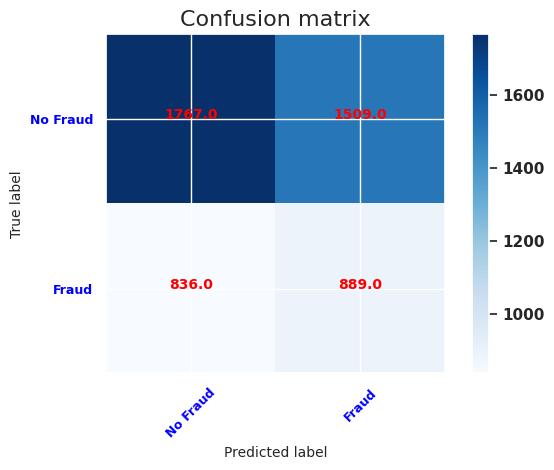

In [317]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.rcParams.update({'font.size': 10})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontdict={'size':'16'})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=9,color="blue")
    plt.yticks(tick_marks, classes,fontsize=9,color="blue")
    rc('font', weight='bold')
    fmt = '.1f'
    thresh = cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")

    plt.ylabel('True label',fontdict={'size':'10'})
    plt.xlabel('Predicted label',fontdict={'size':'10'})
    plt.tight_layout()

plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred), classes=['No Fraud','Fraud'],
                      title='Confusion matrix')

In [318]:
coefficients = model.coef_[0]  # İkili sınıflandırma için
print("Katsayılar:", coefficients)

# Mutlak değerlerle önem sıralaması
feature_importance = np.abs(coefficients)
print("Özellik önemleri (mutlak değer):", feature_importance)

Katsayılar: [ 0.9849329  -0.23916786  0.26635267  0.29797699  0.05726145  0.7536257
  0.5715053  -0.18670871 -0.18044228  0.02979678 -0.24151707 -0.03562932
  0.05220163 -0.00591616 -0.00955171  0.00605373 -0.02223327 -0.04369138
 -0.05736097  0.         -0.00591616 -0.00955171  0.00605373 -0.02223327
 -0.04369138 -0.05736097  0.         -0.13407932 -0.35203717 -0.49062145
 -0.27044736  0.0431779   0.         -0.19578795 -0.31653509  0.02430899
  0.          0.06627318 -0.16017587 -0.16137513  0.         -0.04657842
 -0.18766709 -0.21399794  0.09451134  0.19026725 -0.20845818 -0.12194972
  0.1632652   0.10074858 -0.26214289 -0.01835272  0.08102435  0.09481352
 -0.27389387]
Özellik önemleri (mutlak değer): [0.9849329  0.23916786 0.26635267 0.29797699 0.05726145 0.7536257
 0.5715053  0.18670871 0.18044228 0.02979678 0.24151707 0.03562932
 0.05220163 0.00591616 0.00955171 0.00605373 0.02223327 0.04369138
 0.05736097 0.         0.00591616 0.00955171 0.00605373 0.02223327
 0.04369138 0.0573

In [319]:
def plot_importance(model, features, num=None, save=False, use_abs=True, show_percentage=False):
    """
    Logistic Regression modeli için özellik önemlerini görselleştirir

    Parameters:
    - model: Eğitilmiş LogisticRegression modeli
    - features: Özellik DataFrame'i (X)
    - num: Gösterilecek özellik sayısı (varsayılan: tüm özellikler)
    - save: Grafiği kaydet (True/False)
    - use_abs: Mutlak değer kullan (True/False)
    - show_percentage: Yüzdelik gösterim kullan (True/False)
    """

    if num is None:
        num = len(features.columns)

    # Katsayıları al (ikili sınıflandırma için [0] indeksi)
    if len(model.coef_.shape) > 1:
        coefficients = model.coef_[0]
    else:
        coefficients = model.coef_

    # Mutlak değer kullanılıp kullanılmayacağına karar ver
    if use_abs:
        importance_values = np.abs(coefficients)
        title = 'Feature Importance'
    else:
        importance_values = coefficients
        title = 'Feature Coefficients'

    # Yüzdelik hesaplama
    if show_percentage and use_abs:
        # Katkı yüzdesi formülü: (|katsayı_i| / Σ|tüm_katsayılar|) × 100
        total_importance = np.sum(np.abs(coefficients))
        importance_values = (np.abs(coefficients) / total_importance) * 100
        title += ' (%)'
        x_label = 'Yüzde Katkı (%)'
    elif show_percentage and not use_abs:
        print("Uyarı: Negatif katsayılar olduğunda yüzdelik hesaplama önerilmez!")
        x_label = 'Coefficient Value'
    else:
        x_label = 'Importance Value'

    # DataFrame oluştur
    feature_imp = pd.DataFrame({
        'Value': importance_values,
        'Feature': features.columns
    })

    # Kümülatif yüzde hesapla (sadece mutlak değer ve yüzde modunda)
    if show_percentage and use_abs:
        feature_imp_sorted = feature_imp.sort_values(by="Value", ascending=False)
        feature_imp_sorted['Cumulative_%'] = feature_imp_sorted['Value'].cumsum()

        # %90'a ulaşan özellik sayısını bul
        features_90 = len(feature_imp_sorted[feature_imp_sorted['Cumulative_%'] <= 90])
        print(f"İlk {features_90} özellik modelin %90'ını temsil ediyor.")
        print(f"Top 10 özelliğin kümülatif katkısı: %{feature_imp_sorted.head(10)['Cumulative_%'].iloc[-1]:.1f}")

    # Görselleştirme
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)

    plot_data = feature_imp.sort_values(by="Value", ascending=False)[0:num]

    sns.barplot(
        x="Value",
        y="Feature",
        data=plot_data
    )
    plt.title(f"{title} ({target})" )
    plt.xlabel(x_label)
    plt.tight_layout()
    plt.show()

    if save:
        filename = 'logistic_importances_pct.png' if show_percentage else 'logistic_importances.png'
        plt.savefig(filename)

    return feature_imp.sort_values(by="Value", ascending=False)

İlk 27 özellik modelin %90'ını temsil ediyor.
Top 10 özelliğin kümülatif katkısı: %57.8


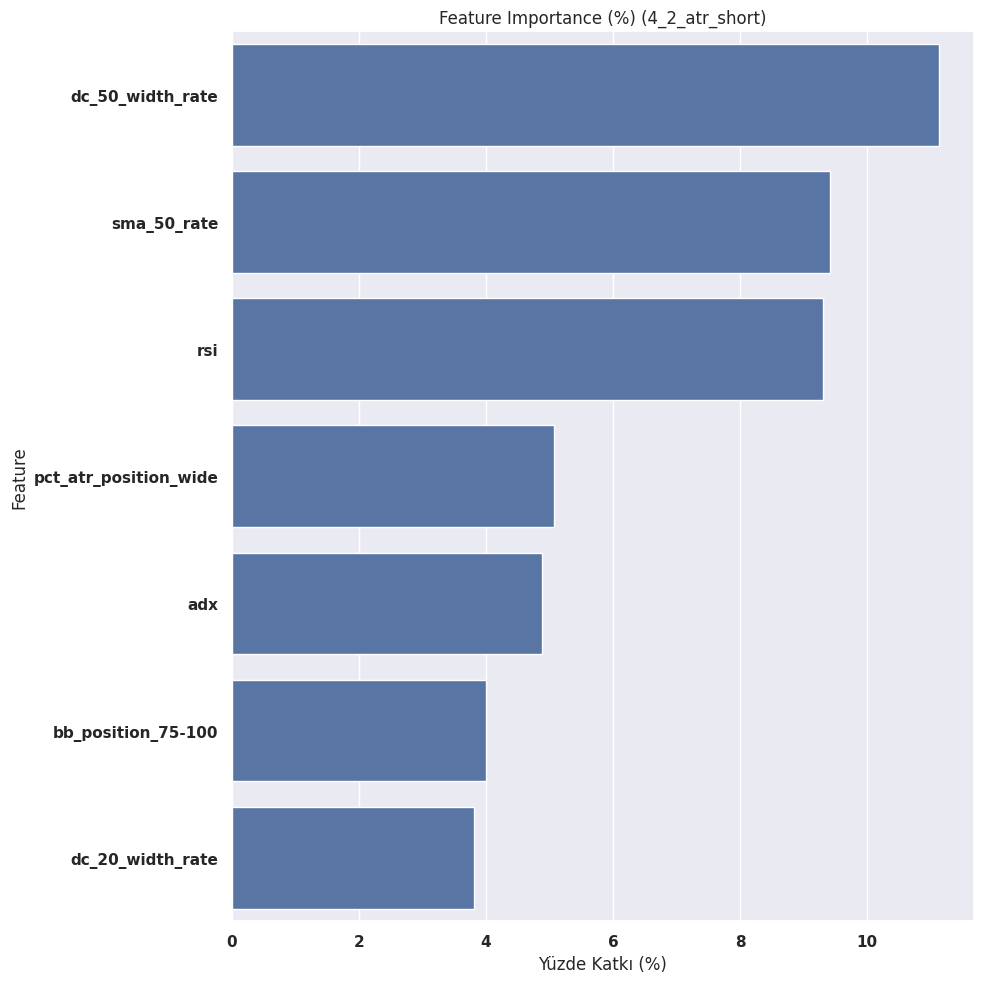

,Value,Feature
4,11.1249753243,dc_50_width_rate
2,9.4085210911,sma_50_rate
0,9.3028193544,rsi
54,5.0799992315,pct_atr_position_wide
6,4.8890274900,adx
29,4.0045984792,bb_position_75-100
5,3.8098777640,dc_20_width_rate
30,3.5115422197,bb_position_above_100
46,3.3505632342,dc_breakdown_clean_50_True
43,3.2772240996,bb_3_touch_long_clean_True


In [348]:
plot_importance(model, X, num=7, show_percentage=True)

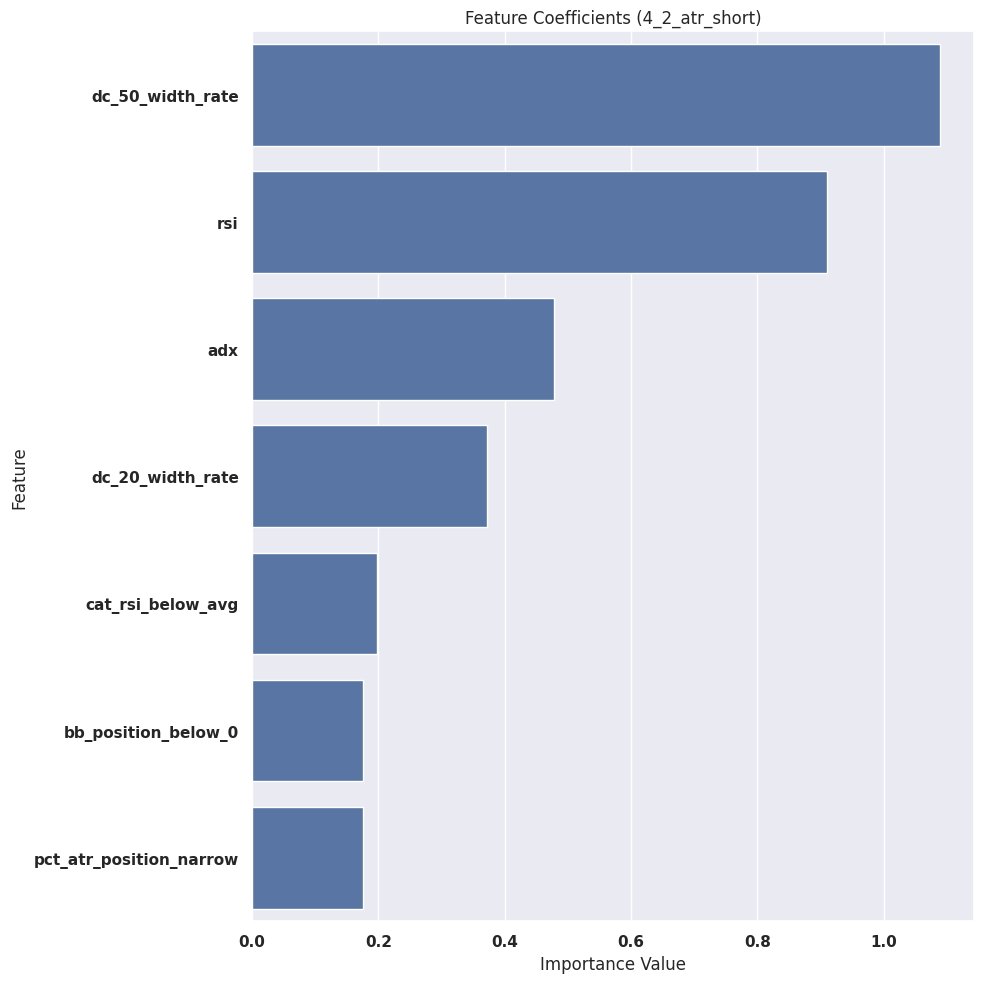

,Value,Feature
4,1.0884871638,dc_50_width_rate
0,0.9102042170,rsi
6,0.4783510535,adx
5,0.3727651452,dc_20_width_rate
37,0.1972549297,cat_rsi_below_avg
31,0.1760112125,bb_position_below_0
53,0.1760034023,pct_atr_position_narrow
9,0.1673335515,candle_class_strong_bearish
39,0.1504796419,cat_rsi_oversold
12,0.1468765941,candle_class_weak_bullish


In [350]:
plot_importance(model, X, num=7, use_abs=False)

In [322]:
def get_top_features_90_percent(model, features):
    """
    Modelin %90'ını temsil eden özellikleri bulur

    Returns:
    - DataFrame: Özellikler ve kümülatif yüzdeleri
    - int: %90'a ulaşmak için gereken özellik sayısı
    """

    # Katsayıları al
    if len(model.coef_.shape) > 1:
        coefficients = model.coef_[0]
    else:
        coefficients = model.coef_

    # Yüzdelik katkı hesapla
    abs_coefficients = np.abs(coefficients)
    total_importance = np.sum(abs_coefficients)
    percentages = (abs_coefficients / total_importance) * 100

    # DataFrame oluştur
    feature_imp = pd.DataFrame({
        'Feature': features.columns,
        'Importance_%': percentages,
        'Abs_Coefficient': abs_coefficients
    }).sort_values(by='Importance_%', ascending=False)

    # Kümülatif yüzde
    feature_imp['Cumulative_%'] = feature_imp['Importance_%'].cumsum()

    # %90'a ulaşan özellik sayısı
    features_90 = len(feature_imp[feature_imp['Cumulative_%'] <= 90])

    return feature_imp, features_90

In [323]:
#  %90 analizi için ayrı fonksiyon
top_features, count_90 = get_top_features_90_percent(model, X)
print(f"İlk {count_90} özellik modelin %90'ını açıklıyor")
print(top_features.head(count_90))

İlk 26 özellik modelin %90'ını açıklıyor
                             Feature  Importance_%  Abs_Coefficient  Cumulative_%
0                                rsi 11.6433013544     0.9849329003 11.6433013544
5                   dc_20_width_rate  8.9089227509     0.7536256991 20.5522241054
6                                adx  6.7560018242     0.5715053032 27.3082259295
29                bb_position_75-100  5.7998401834     0.4906214517 33.1080661129
28                 bb_position_50-75  4.1615777851     0.3520371717 37.2696438980
34   adx_category_super_strong_trend  3.7418929343     0.3165350916 41.0115368323
3                      bb_width_rate  3.5225099495     0.2979769943 44.5340467818
54             pct_atr_position_wide  3.2378132739     0.2738938658 47.7718600556
30             bb_position_above_100  3.1970706960     0.2704473600 50.9689307517
2                        sma_50_rate  3.1486656926     0.2663526725 54.1175964443
50    dc_20_width_rate_position_wide  3.0989001570     0.

# y_proba

In [324]:
dff['rsi_40'].describe()

,rsi_40
count,20002.0000000000
mean,0.5005677513
std,0.1561639985
min,0.0000000000
25%,0.3848480811
50%,0.4986827648
75%,0.6094247852
max,1.0000000000
